#### 1. Implementing XGBoost Algorithm

In [1]:
#🧩 Step 1: Load the Scaled Dataset

In [2]:
import pandas as pd

# Load the scaled dataset
df = pd.read_csv('scaled_CVD_Dataset.csv')

In [3]:
# Display first few rows
df.head()

,Age,Pulse Rate,Systolic Pressure,Diastolic Pressure,Respiratory Rate,Temperature,Weight,BMI,Total Cholesterol,Risk Factor_Dyslamapedia,...,Musculoskeletal System_Yes,Diagnosis_Endocrine Disorders,Diagnosis_Infectious Diseases,Diagnosis_Surgical Conditions,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,CVD_Yes
0,-0.220730,-0.632570,-0.675769,-0.181866,0.250619,-0.296989,-2.646255,-1.747322,-0.089204,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,-0.451464,-0.442924,False
1,-1.692960,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,0.015068,-1.747322,2.012453,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
2,-0.017664,1.094266,1.819467,1.775250,2.721419,4.875546,0.015068,-1.747322,0.141115,-0.719817,...,-0.624402,1.441931,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
3,0.693068,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,-2.625571,-1.721482,0.515383,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,-0.445237,-0.444544,-0.451464,2.257724,True
4,0.439235,0.687951,-0.546705,-0.181866,0.250619,-0.167676,-2.797936,-1.682720,-0.808949,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,2.215016,-0.442924,False


In [4]:
#🧩 Step 2: Split Features and Target
# Separate features (X) and target variable (y)
X = df.drop('CVD_Yes', axis=1)  
y = df['CVD_Yes']

In [5]:
#🧩 Step 3: Split into Training and Test Sets
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#### Define the Model

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Define the base model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Apply GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',  # You can also try 'accuracy' or 'roc_auc'
    verbose=1,
    n_jobs=-1
)

# Fit GridSearch to the training data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters Found:")
print(grid_search.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


#### Train the Model

In [7]:
# Train XGBoost with best parameters
best_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

best_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

#### Model Prediction

In [8]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict on test data
y_pred = best_model.predict(X_test)

# If best_model doesn't output probabilities, use predict_proba (for AUC-ROC)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for class 1 (CVD Yes)

# Map numeric labels to meaningful class names (if 1 = CVD Yes, 0 = CVD No)
target_names = ['CVD No', 'CVD Yes']

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

print("Accuracy:", round(accuracy, 3))
print("AUC-ROC:", round(auc_roc, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.874
AUC-ROC: 0.955

Classification Report:
               precision    recall  f1-score   support

      CVD No       0.91      0.82      0.86      2044
     CVD Yes       0.84      0.93      0.88      2142

    accuracy                           0.87      4186
   macro avg       0.88      0.87      0.87      4186
weighted avg       0.88      0.87      0.87      4186



#### Visualizing Classification Report

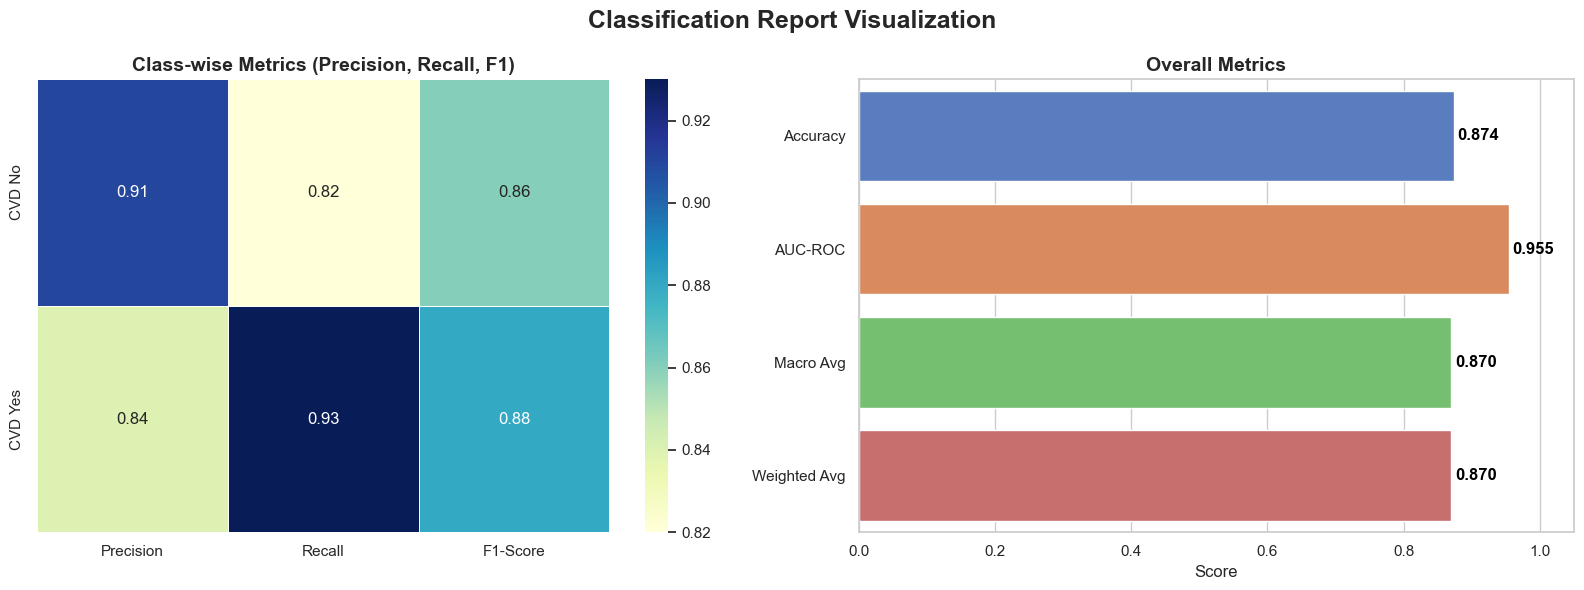

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define classification metrics manually (based on your output)
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [0.91, 0.84],
    'Recall': [0.82, 0.93],
    'F1-Score': [0.86, 0.88]
}

# Convert to DataFrame
class_df = pd.DataFrame(metrics_data)

# Overall metrics including AUC-ROC
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [0.874, 0.955, 0.87, 0.87]  # Rounded to 3 decimals
}
overall_df = pd.DataFrame(overall_metrics)

# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Classification Report Visualization", fontsize=18, fontweight='bold')

# --- Heatmap for Class Metrics ---
sns.heatmap(class_df.set_index('Class'), annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, ax=ax1)
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')

# --- Bar Chart for Overall Metrics ---
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2)

# Add labels to bars
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.3f}", color='black', va='center', fontweight='bold')

ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics', fontsize=14, fontweight='bold')
ax2.set_xlabel('Score')
ax2.set_ylabel('')

# Layout adjustment
plt.tight_layout()
plt.show()


#### Ploating Confussion Matrics

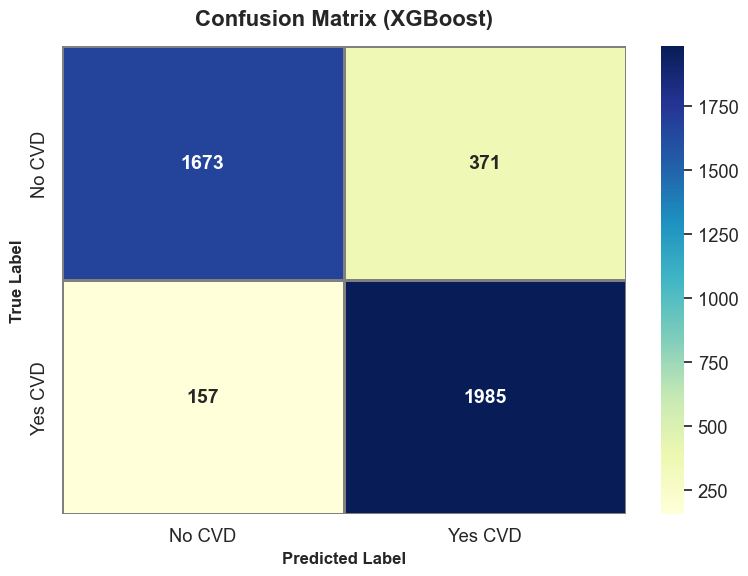

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['No CVD', 'Yes CVD']

# Plot with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True, 
            xticklabels=labels, yticklabels=labels, linewidths=1, linecolor='gray', annot_kws={"size": 14, "weight": "bold"})

# Customize labels and title
plt.title('Confusion Matrix (XGBoost)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

#### Visualizing Training and Testing Accuracy

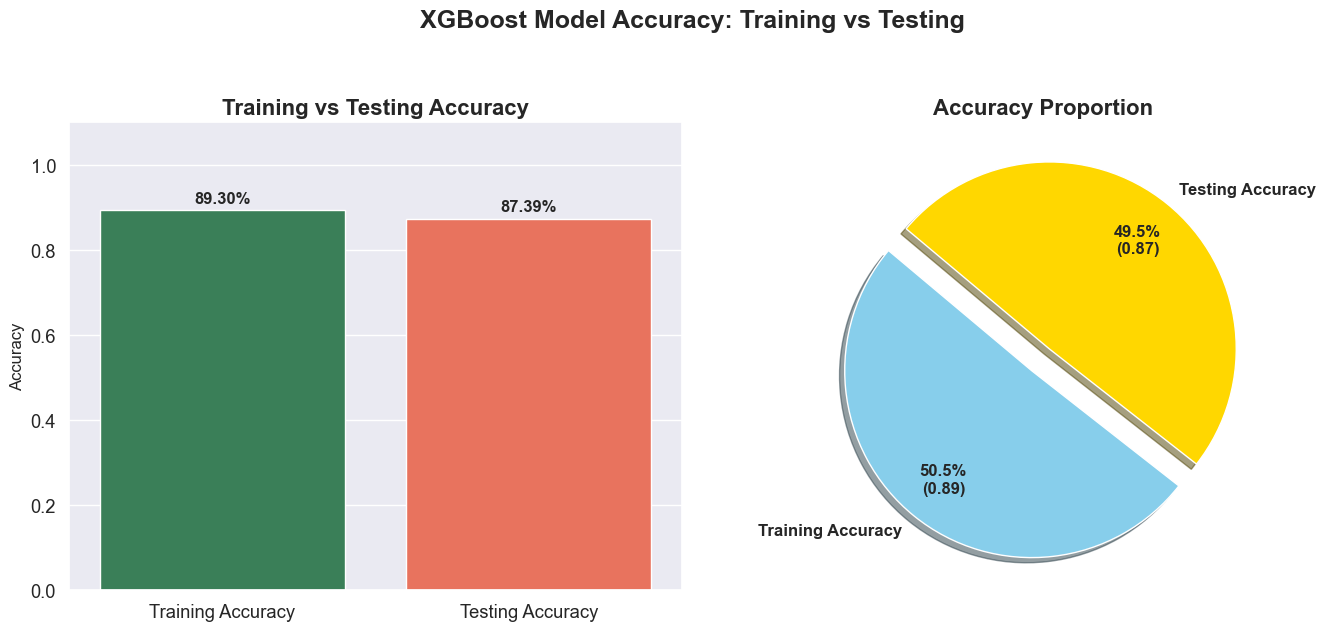

In [11]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate training and testing accuracy
train_acc = accuracy_score(y_train, best_model.predict(X_train))
test_acc = accuracy_score(y_test, best_model.predict(X_test))

# Create DataFrame
acc_df = pd.DataFrame({
    'Dataset': ['Training Accuracy', 'Testing Accuracy'],
    'Accuracy': [train_acc, test_acc]
})

# Define custom color palette
bar_colors = ['#2E8B57', '#FF6347']  # Green and Tomato
pie_colors = ['#87CEEB', '#FFD700']  # Sky Blue and Gold
explode = (0.1, 0.05)  # Explode slices for emphasis

# Custom autopct function to show percentage and actual value
def autopct_format(pct, allvals):
    absolute = pct * sum(allvals) / 100
    return f"{pct:.1f}%\n({absolute:.2f})"

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

# --- Bar Chart ---
sns.barplot(x='Dataset', y='Accuracy', data=acc_df, palette=bar_colors, ax=axes[0])

# Add text labels to bars
for index, row in acc_df.iterrows():
    axes[0].text(index, row.Accuracy + 0.01, f"{row.Accuracy:.2%}",
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

# Customize bar chart
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Training vs Testing Accuracy', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('')

# --- Pie Chart ---
axes[1].pie(
    acc_df['Accuracy'],
    labels=acc_df['Dataset'],
    autopct=lambda pct: autopct_format(pct, acc_df['Accuracy']),
    colors=pie_colors,
    explode=explode,
    shadow=True,
    startangle=140,
    pctdistance=0.75,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[1].set_title('Accuracy Proportion', fontsize=16, fontweight='bold')

# Add a common title for the figure
fig.suptitle('XGBoost Model Accuracy: Training vs Testing', fontsize=18, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()


#### Model Interpretablity SHAP

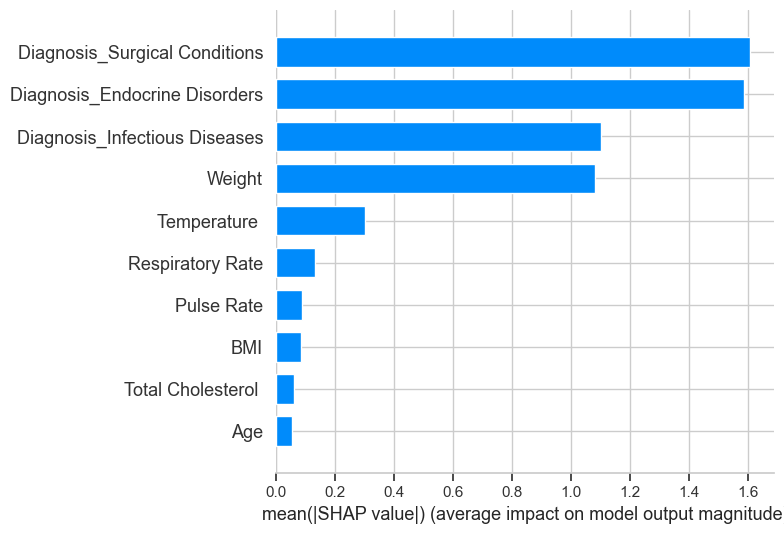

In [163]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Ensure X_train is a pandas DataFrame with feature names
# If X_train is a numpy array, convert it:
# X_train = pd.DataFrame(X_train, columns=feature_names)

# Create SHAP explainer for your XGBoost model
explainer = shap.Explainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot SHAP summary bar plot of top 10 features
shap.summary_plot(shap_values, X_train, max_display=10, plot_type='bar')


#### Model Interpretablity Using LIME

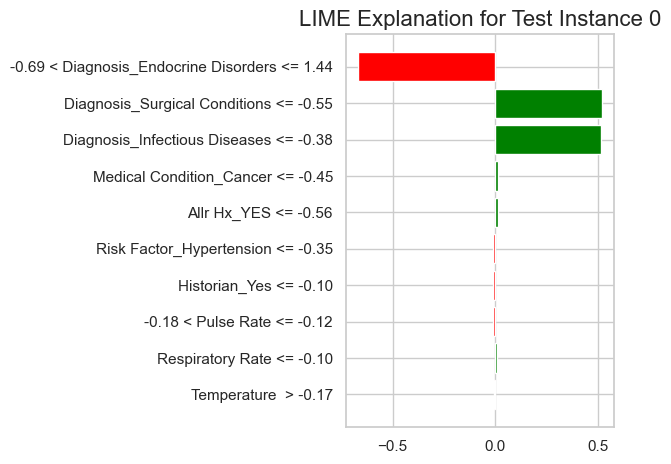

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from IPython.display import display  # Correct import for display

# Assuming you already have:
# - best_model trained (XGBoost)
# - X_train, X_test as numpy arrays or pandas DataFrames
# - y_train, y_test as arrays/series

# Example: Use first test instance to explain prediction
i = 0
instance = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]

# If X_train is a DataFrame, extract feature names and class names
feature_names = X_train.columns.tolist() if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
class_names = ['CVD No', 'CVD Yes']

# Create LIME explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Get explanation for the instance (convert to numpy if DataFrame)
exp = explainer.explain_instance(
    data_row=np.array(instance),
    predict_fn=best_model.predict_proba,
    num_features=10
)


# Or save the explanation as HTML file
# exp.save_to_file('lime_explanation.html')

# Plot explanation as bar chart (matplotlib)
fig = exp.as_pyplot_figure()
plt.title(f'LIME Explanation for Test Instance {i}', fontsize=16)
plt.tight_layout()
plt.show()


#### 2. Implementing Deep Random Forest Algorithm

In [12]:
## Step 1: Load dataset and spliting
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your scaled dataset
df = pd.read_csv('scaled_CVD_Dataset.csv')

# Define features and target
X = df.drop(columns=['CVD_Yes'])
y = df['CVD_Yes']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
# Step 2: Hyperparameter tuning with RandomizedSearchCV for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, verbose=2)

In [14]:
## Step 3: Train the best model from hyperparameter tuning
print("Best hyperparameters:", random_search.best_params_)

best_rf = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
#save the model
import joblib  
joblib.dump(best_rf, 'best_random_forest_model.pkl')


Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


['best_random_forest_model.pkl']

In [15]:
## Step 4: Predict and evaluate (Accuracy, AUC-ROC, Classification Report)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # probabilities for positive class

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes']))


Accuracy: 0.8683707596751075
AUC-ROC: 0.9493041508840981

Classification Report:
               precision    recall  f1-score   support

      CVD No       0.90      0.83      0.86      2044
     CVD Yes       0.85      0.91      0.88      2142

    accuracy                           0.87      4186
   macro avg       0.87      0.87      0.87      4186
weighted avg       0.87      0.87      0.87      4186



#### Visualizing Classification Report

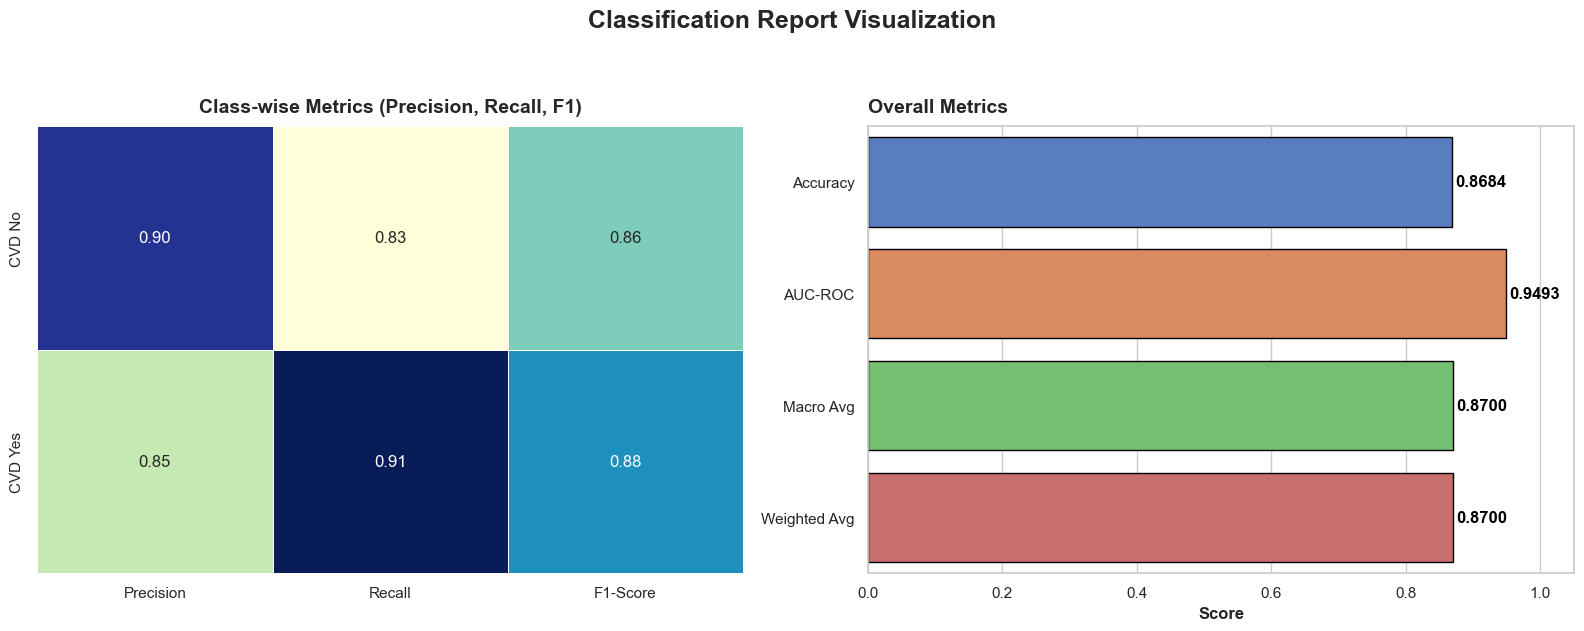

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Define classification metrics manually based on your output
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [0.90, 0.85],
    'Recall': [0.83, 0.91],
    'F1-Score': [0.86, 0.88]
}

# Convert to DataFrame
class_df = pd.DataFrame(metrics_data)

# Overall metrics including AUC-ROC
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [0.8684, 0.9493, 0.87, 0.87]  # Rounded to 4 decimals
}
overall_df = pd.DataFrame(overall_metrics)

# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
# Set a common title for the figure
fig.suptitle("Classification Report Visualization", fontsize=18, fontweight='bold', y=1.05)

# --- Heatmap for Class Metrics ---
sns.heatmap(class_df.set_index('Class'), annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, ax=ax1, cbar=False)
# Add labels to heatmap
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('')

# --- Bar Chart for Overall Metrics ---
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2, edgecolor='black')

# Add labels to bars
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.4f}", color='black', va='center', fontweight='bold', fontsize=12)
# Customize bar chart
ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics', fontsize=14, fontweight='bold', pad=10, loc='left')
# Set labels
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

# Layout adjustment
plt.tight_layout()
plt.show()


#### Ploating Confussion Matrics

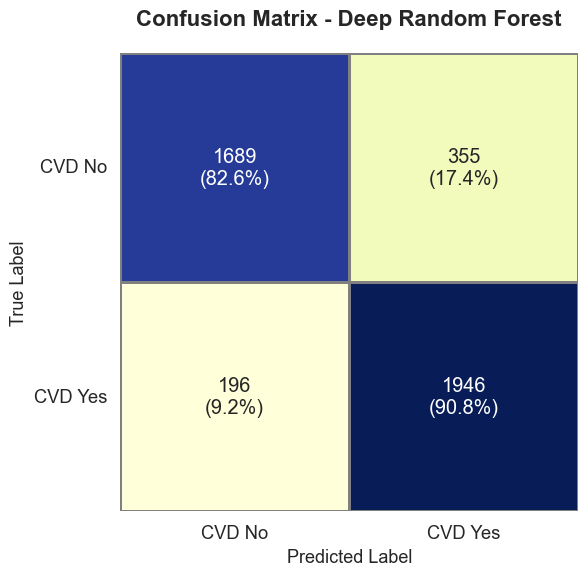

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # row-normalized percentages

labels = ['CVD No', 'CVD Yes']

# Set up the matplotlib figure
plt.figure(figsize=(11, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Create a heatmap with both counts and percentages
ax = sns.heatmap(
    cm, 
    annot=np.array([["{0}\n({1:.1%})".format(count, percent) for count, percent in zip(row, cm_percent_row)] 
                    for row, cm_percent_row in zip(cm, cm_percent)]),
    fmt='', 
    cmap='YlGnBu', 
    cbar=False,
    xticklabels=labels, 
    yticklabels=labels,
    linewidths=1, 
    linecolor='gray',
    square=True
)

# Axis and title formatting
plt.title('Confusion Matrix - Deep Random Forest', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

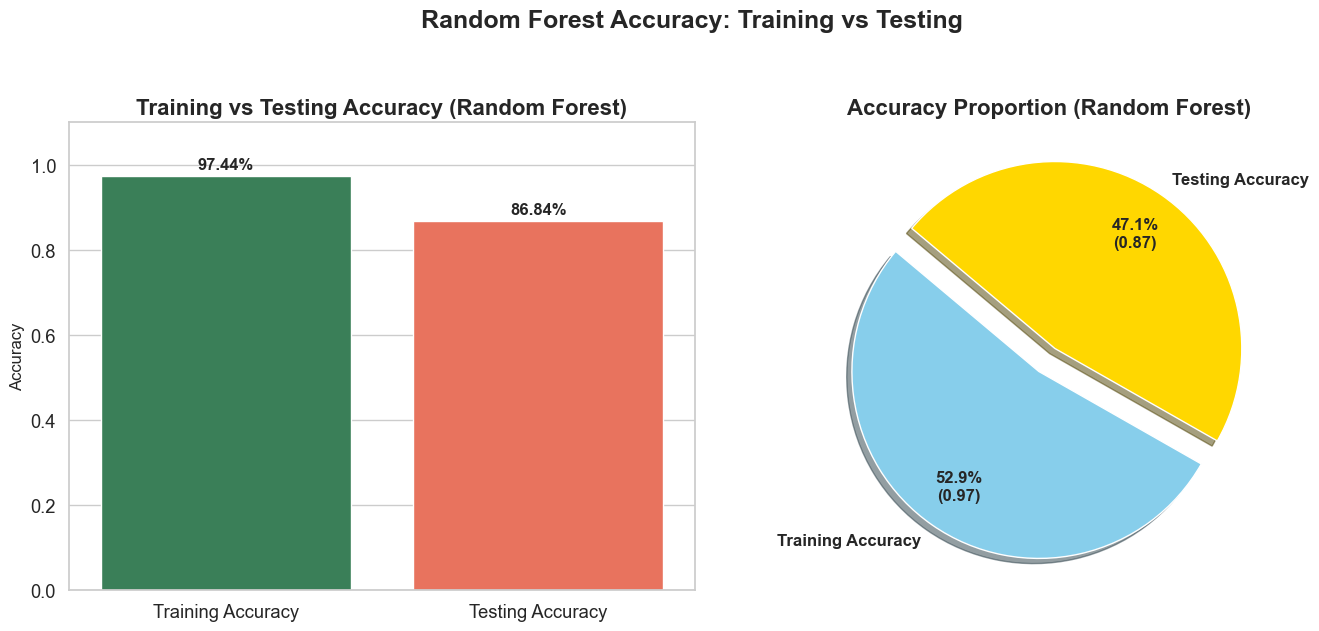

In [21]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate training and testing accuracy for best_rf
train_acc = accuracy_score(y_train, best_rf.predict(X_train))
test_acc = accuracy_score(y_test, best_rf.predict(X_test))

# Create DataFrame
acc_df = pd.DataFrame({
    'Dataset': ['Training Accuracy', 'Testing Accuracy'],
    'Accuracy': [train_acc, test_acc]
})

# Define custom color palette
bar_colors = ['#2E8B57', '#FF6347']  # Green and Tomato
pie_colors = ['#87CEEB', '#FFD700']  # Sky Blue and Gold
explode = (0.1, 0.05)  # Explode slices for emphasis

# Custom autopct function to show percentage and actual value
def autopct_format(pct, allvals):
    absolute = pct * sum(allvals) / 100
    return f"{pct:.1f}%\n({absolute:.2f})"

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

# --- Bar Chart ---
sns.barplot(x='Dataset', y='Accuracy', data=acc_df, palette=bar_colors, ax=axes[0])

# Add text labels to bars
for index, row in acc_df.iterrows():
    axes[0].text(index, row.Accuracy + 0.01, f"{row.Accuracy:.2%}",
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

# Customize bar chart
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Training vs Testing Accuracy (Random Forest)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('')

# --- Pie Chart ---
axes[1].pie(
    acc_df['Accuracy'],
    labels=acc_df['Dataset'],
    autopct=lambda pct: autopct_format(pct, acc_df['Accuracy']),
    colors=pie_colors,
    explode=explode,
    shadow=True,
    startangle=140,
    pctdistance=0.75,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[1].set_title('Accuracy Proportion (Random Forest)', fontsize=16, fontweight='bold')

# Add a common title for the figure
fig.suptitle('Random Forest Accuracy: Training vs Testing', fontsize=18, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()


#### Model Interpretablity Using SHAP

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ Convert X_train to DataFrame if needed
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=feature_names)

# ✅ SHAP Explainer
explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_train)

# ✅ Compute Information Gain-based importances (from Random Forest)
info_gain_importances = best_rf.feature_importances_
info_gain_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': info_gain_importances
}).sort_values(by='Importance', ascending=False).head(10)

# ✅ SHAP Summary Plot (Top 10)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_train, max_display=10, plot_type='bar')
plt.title("Top 10 SHAP Feature Importances", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ✅ Plot Information Gain Importances
plt.figure(figsize=(12, 6))
sns.barplot(data=info_gain_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Features by Information Gain (Random Forest)", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Information Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


  1%|                   | 438/33480 [00:57<71:39]       

#### Model Interpretablity Using LIME

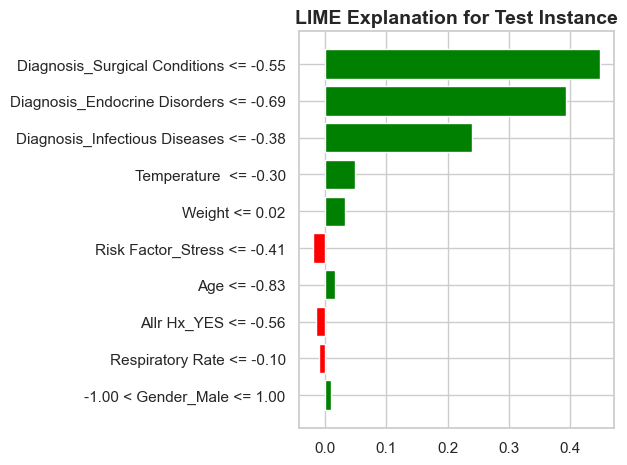

In [11]:
# Required Imports
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X_train is a DataFrame
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

# Create LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_df.values,
    feature_names=X_train_df.columns,
    class_names=['CVD No', 'CVD Yes'],
    mode='classification'
)

# Select instance to explain
i = 25  # Change index as needed
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=best_rf.predict_proba,
    num_features=10
)

# Static visualization using matplotlib
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.title("LIME Explanation for Test Instance", fontsize=14, fontweight='bold')
plt.show()


#### 3.Implementing Gradient Boosting Machine Algorithm

In [22]:
#Step 1: Load the Dataset
import pandas as pd

# Load the scaled dataset
df = pd.read_csv('scaled_CVD_Dataset.csv')
df.head()


,Age,Pulse Rate,Systolic Pressure,Diastolic Pressure,Respiratory Rate,Temperature,Weight,BMI,Total Cholesterol,Risk Factor_Dyslamapedia,...,Musculoskeletal System_Yes,Diagnosis_Endocrine Disorders,Diagnosis_Infectious Diseases,Diagnosis_Surgical Conditions,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,CVD_Yes
0,-0.220730,-0.632570,-0.675769,-0.181866,0.250619,-0.296989,-2.646255,-1.747322,-0.089204,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,-0.451464,-0.442924,False
1,-1.692960,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,0.015068,-1.747322,2.012453,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
2,-0.017664,1.094266,1.819467,1.775250,2.721419,4.875546,0.015068,-1.747322,0.141115,-0.719817,...,-0.624402,1.441931,-0.382431,-0.546832,-0.447085,2.245993,-0.444544,-0.451464,-0.442924,True
3,0.693068,-0.124677,-0.546705,-0.229600,-0.102353,-0.296989,-2.625571,-1.721482,0.515383,-0.719817,...,-0.624402,-0.693515,-0.382431,-0.546832,-0.447085,-0.445237,-0.444544,-0.451464,2.257724,True
4,0.439235,0.687951,-0.546705,-0.181866,0.250619,-0.167676,-2.797936,-1.682720,-0.808949,-0.719817,...,-0.624402,-0.693515,-0.382431,1.828715,-0.447085,-0.445237,-0.444544,2.215016,-0.442924,False


In [23]:
# Step 2: Prepare Features and Target
# Define features and target
X = df.drop(columns=['CVD_Yes'])  # Drop target column
y = df['CVD_Yes']

# Check shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (20926, 26)
Target shape: (20926,)


In [24]:
# Step 3: Split Data into Train and Test Sets
from sklearn.model_selection import train_test_split

# Split into training and testing data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 16740
Testing samples: 4186


In [25]:
# Step 4: Hyperparameter Tuning with GridSearchCV for GBM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Instantiate GBM classifier
gbm = GradientBoostingClassifier(random_state=42)

# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [26]:
#Step 5: Train GBM Model with Best Parameters
# Get best estimator
best_gbm = grid_search.best_estimator_

# Fit best GBM on full training data
best_gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,
                           random_state=42)

In [27]:
# Step 6: Evaluate the Model on Test Set
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Predict on test data
y_pred = best_gbm.predict(X_test)
y_proba = best_gbm.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes'])

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("\nClassification Report:\n", report)


Accuracy: 0.8736
AUC-ROC: 0.9552

Classification Report:
               precision    recall  f1-score   support

      CVD No       0.91      0.82      0.86      2044
     CVD Yes       0.84      0.93      0.88      2142

    accuracy                           0.87      4186
   macro avg       0.88      0.87      0.87      4186
weighted avg       0.88      0.87      0.87      4186



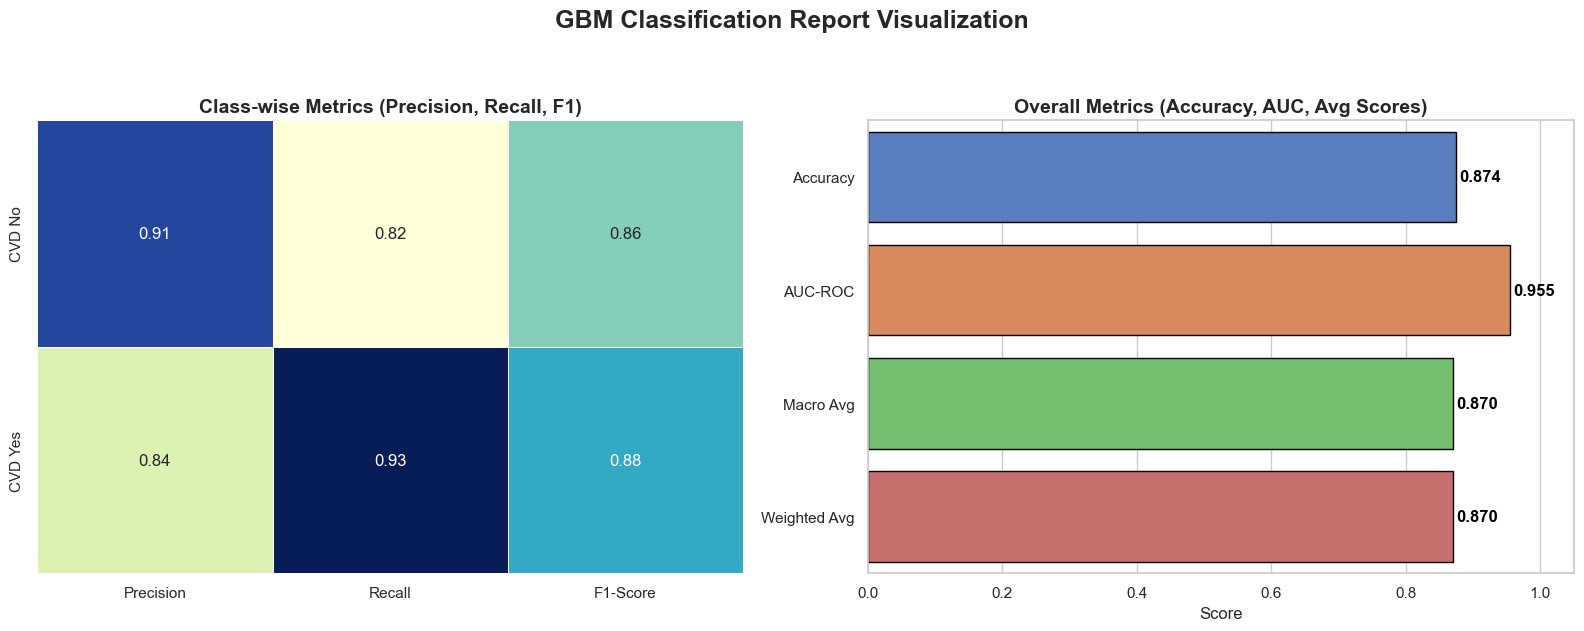

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# === Class-wise Metrics ===
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [0.91, 0.84],
    'Recall': [0.82, 0.93],
    'F1-Score': [0.86, 0.88]
}
class_df = pd.DataFrame(metrics_data)

# === Overall Metrics ===
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [0.874, 0.955, 0.87, 0.87]
}
overall_df = pd.DataFrame(overall_metrics)

# === Plot Settings ===
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.suptitle("GBM Classification Report Visualization", fontsize=18, fontweight='bold', y=1.05)

# === Heatmap for Class-wise Precision, Recall, F1 ===
sns.heatmap(
    class_df.set_index('Class'),
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    linewidths=0.5,
    ax=ax1,
    cbar=False
)
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')

# === Bar Chart for Overall Metrics ===
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2, edgecolor='black')

# Add labels to bars
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.3f}", color='black', va='center', fontweight='bold', fontsize=12)

ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics (Accuracy, AUC, Avg Scores)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Score', fontsize=12)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


#### Ploting Confussion Matrics

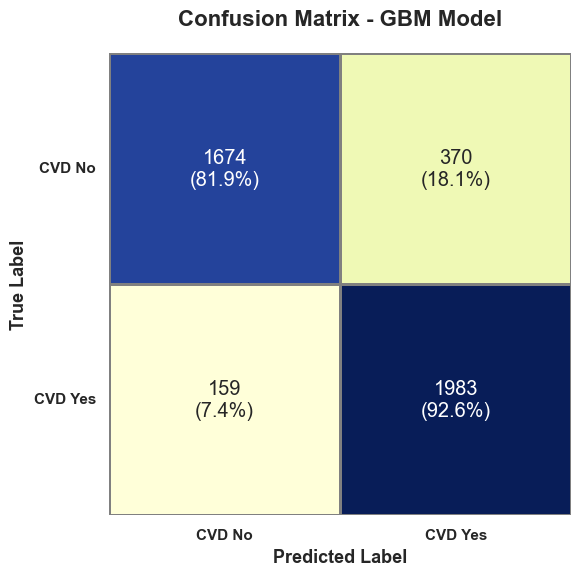

In [164]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Predict using the GBM model ===
y_pred_gbm = best_gbm.predict(X_test)

# === Compute confusion matrix and normalize ===
cm = confusion_matrix(y_test, y_pred_gbm)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # row-normalized percentages

labels = ['CVD No', 'CVD Yes']

# === Plot setup ===
plt.figure(figsize=(11, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# === Create heatmap with counts and percentages ===
annot = np.array([
    ["{0}\n({1:.1%})".format(count, percent) for count, percent in zip(row, cm_percent_row)]
    for row, cm_percent_row in zip(cm, cm_percent)
])

ax = sns.heatmap(
    cm, 
    annot=annot,
    fmt='', 
    cmap='YlGnBu', 
    cbar=False,
    xticklabels=labels, 
    yticklabels=labels,
    linewidths=1, 
    linecolor='gray',
    square=True
)

# === Axis and title formatting ===
plt.title('Confusion Matrix - GBM Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=0, fontsize=11, fontweight='bold')
plt.yticks(rotation=0, fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

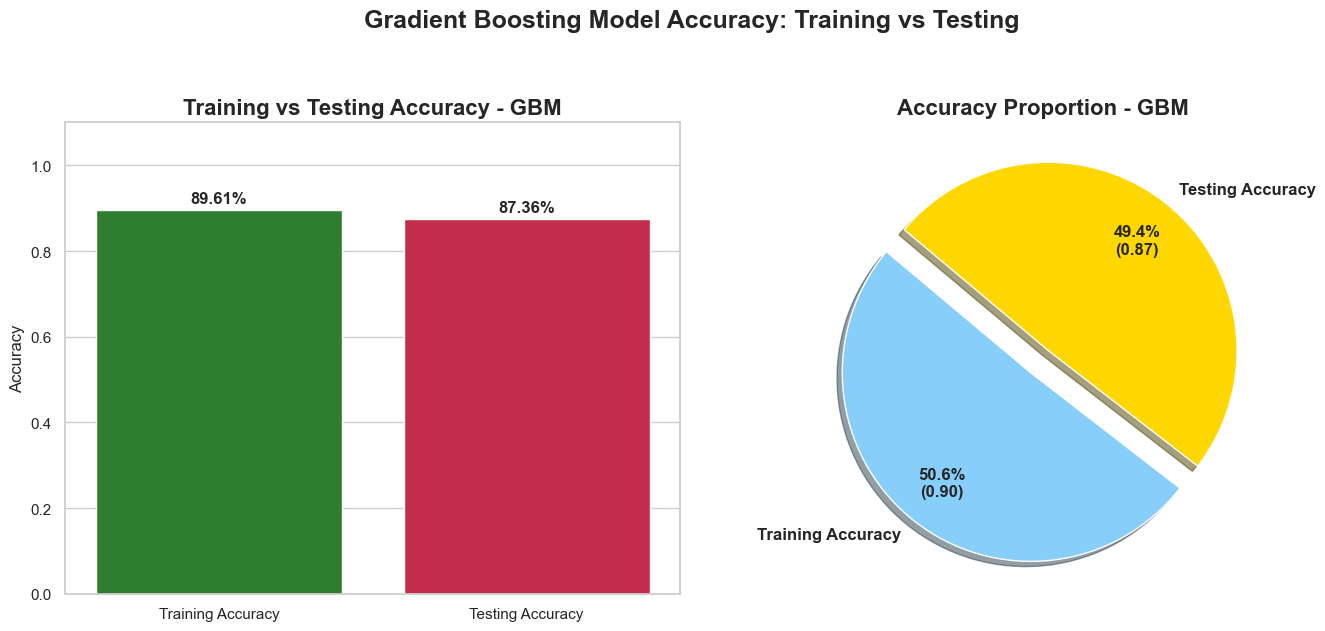

In [30]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Compute Training and Testing Accuracy ===
train_acc_gbm = accuracy_score(y_train, best_gbm.predict(X_train))
test_acc_gbm = accuracy_score(y_test, best_gbm.predict(X_test))

# === Create DataFrame for plotting ===
acc_df_gbm = pd.DataFrame({
    'Dataset': ['Training Accuracy', 'Testing Accuracy'],
    'Accuracy': [train_acc_gbm, test_acc_gbm]
})

# === Define custom color palette ===
bar_colors = ['#228B22', '#DC143C']  # ForestGreen and Crimson
pie_colors = ['#87CEFA', '#FFD700']  # LightSkyBlue and Gold
explode = (0.1, 0.05)  # Slight explode for emphasis

# === Custom label formatting for pie chart ===
def autopct_format(pct, allvals):
    absolute = pct * sum(allvals) / 100
    return f"{pct:.1f}%\n({absolute:.2f})"

# === Create subplots ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

# === Bar Chart ===
sns.barplot(x='Dataset', y='Accuracy', data=acc_df_gbm, palette=bar_colors, ax=axes[0])
for index, row in acc_df_gbm.iterrows():
    axes[0].text(index, row.Accuracy + 0.01, f"{row.Accuracy:.2%}",
                 ha='center', va='bottom', fontweight='bold', fontsize=12)

axes[0].set_ylim(0, 1.1)
axes[0].set_title('Training vs Testing Accuracy - GBM', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('')

# === Pie Chart ===
axes[1].pie(
    acc_df_gbm['Accuracy'],
    labels=acc_df_gbm['Dataset'],
    autopct=lambda pct: autopct_format(pct, acc_df_gbm['Accuracy']),
    colors=pie_colors,
    explode=explode,
    shadow=True,
    startangle=140,
    pctdistance=0.75,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[1].set_title('Accuracy Proportion - GBM', fontsize=16, fontweight='bold')

# === Overall Title and Layout ===
fig.suptitle('Gradient Boosting Model Accuracy: Training vs Testing', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


#### Model Interpretablity Using SHAP

 99%|===================| 16531/16740 [01:06<00:00]        

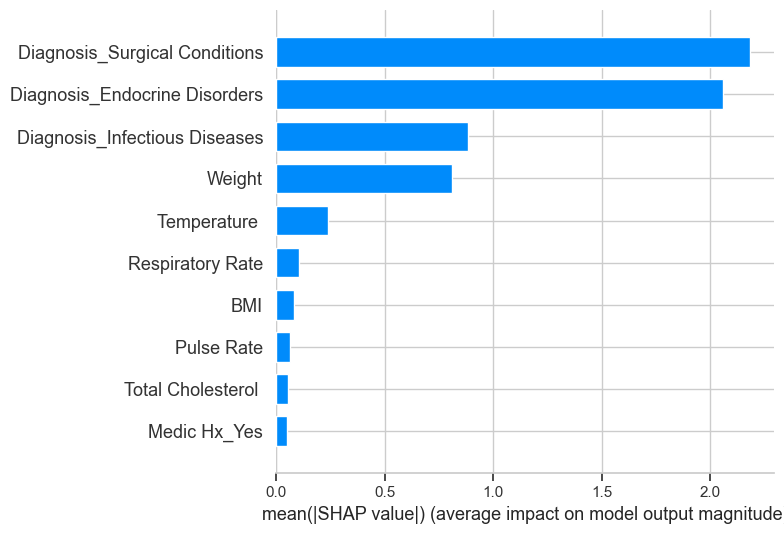

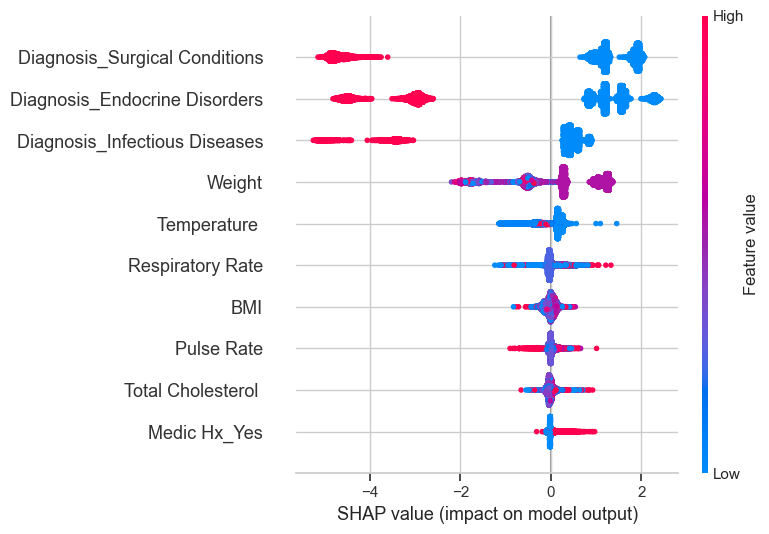

In [18]:
# ✅ Required Libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Ensure X_train is a DataFrame
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

# ✅ Create SHAP Explainer for GBM model
explainer = shap.Explainer(best_gbm, X_train_df)

# ✅ Compute SHAP values
shap_values = explainer(X_train_df)

# ✅ Plot SHAP summary bar plot (Top 10 features)
shap.summary_plot(shap_values, X_train_df, plot_type="bar", max_display=10)

# ✅ Optional: SHAP summary dot plot
shap.summary_plot(shap_values, X_train_df, max_display=10)

# ✅ Optional: Force plot for the first instance (requires Jupyter)
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X_train_df.iloc[0])


#### Model Interpretablity Using LIME

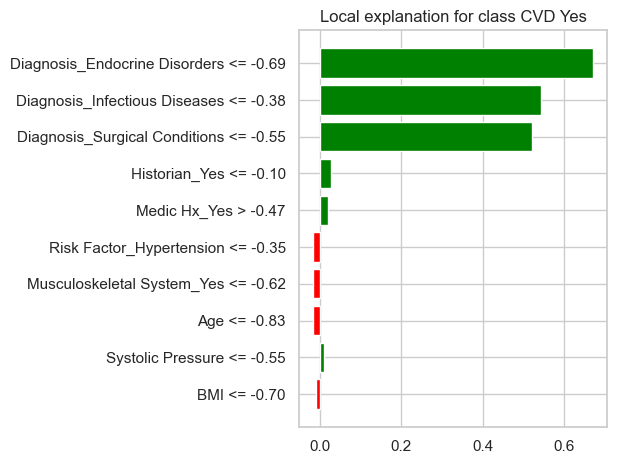

In [20]:
# ✅ Required Libraries
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Ensure X_train is a DataFrame with column names
if isinstance(X_train, np.ndarray):
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
else:
    X_train_df = X_train.copy()

# ✅ Ensure X_test is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
else:
    X_test_df = X_test.copy()

# ✅ Create LIME Explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_df.values,
    feature_names=X_train_df.columns.tolist(),
    class_names=['CVD No', 'CVD Yes'],
    mode='classification'
)

# ✅ Select instance to explain
i = 25  # change this index to explain a different test instance
exp = lime_explainer.explain_instance(
    data_row=X_test_df.iloc[i].values,
    predict_fn=best_gbm.predict_proba,
    num_features=10
)

# Static visualization with matplotlib
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


# ✅ Save explanation as HTML (optional)
exp.save_to_file("lime_gbm_explanation.html")


### Implementing Deep Learning Algorthim

#### 1. LSTM

In [31]:
#✅ Step 1: Load the Scaled Dataset
import pandas as pd

# Load the scaled dataset
df = pd.read_csv('scaled_CVD_Dataset.csv')

# Define features and target
target_column = 'CVD_Yes'  # Confirm target column name here
X = df.drop(columns=[target_column])
y = df[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (20926, 26)
Target shape: (20926,)


In [32]:
#Step 2: Split Dataset and Reshape for LSTM
from sklearn.model_selection import train_test_split
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Reshape input to 3D for LSTM: (samples, timesteps, features)
# Since this is tabular data with no time sequence, set timesteps=1
X_train_lstm = np.expand_dims(X_train.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)

print(f"X_train reshaped for LSTM: {X_train_lstm.shape}")
print(f"X_test reshaped for LSTM: {X_test_lstm.shape}")


Training data shape: (16740, 26)
Testing data shape: (4186, 26)
X_train reshaped for LSTM: (16740, 1, 26)
X_test reshaped for LSTM: (4186, 1, 26)


In [33]:
# Step 3: Build LSTM Model (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,409 (99.25 KB)

 Trainable params: 25,409 (99.25 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#Step 4: Hyperparameter Tuning Using Keras Tuner
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   input_shape=input_shape, return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='cvd_lstm'
)

tuner.search(X_train_lstm, y_train, epochs=10, validation_split=0.2, batch_size=32, verbose=2)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hp.values}")

Reloading Tuner from lstm_tuning\cvd_lstm\tuner0.json
Best hyperparameters: {'units': 32, 'dropout': 0.2, 'dense_units': 16, 'learning_rate': 0.01}


In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Step 5: Train LSTM with Best Hyperparameters and Early Stopping
best_LSTM_model = tuner.hypermodel.build(best_hp)

early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=15,            # Stop if no improvement after 5 epochs
    restore_best_weights=True
)

history = best_LSTM_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks=[early_stopping]  # Add early stopping callback here
)

# Save the best model
#best_model.save('best_lstm_model.h5')


Epoch 1/100
419/419 - 3s - 6ms/step - accuracy: 0.7997 - loss: 0.3446 - val_accuracy: 0.8286 - val_loss: 0.3088
Epoch 2/100
419/419 - 1s - 2ms/step - accuracy: 0.8280 - loss: 0.2975 - val_accuracy: 0.8321 - val_loss: 0.2982
Epoch 3/100
419/419 - 1s - 2ms/step - accuracy: 0.8358 - loss: 0.2876 - val_accuracy: 0.8330 - val_loss: 0.3004
Epoch 4/100
419/419 - 1s - 2ms/step - accuracy: 0.8356 - loss: 0.2844 - val_accuracy: 0.8417 - val_loss: 0.2894
Epoch 5/100
419/419 - 1s - 2ms/step - accuracy: 0.8407 - loss: 0.2803 - val_accuracy: 0.8393 - val_loss: 0.2919
Epoch 6/100
419/419 - 1s - 2ms/step - accuracy: 0.8422 - loss: 0.2758 - val_accuracy: 0.8465 - val_loss: 0.2841
Epoch 7/100
419/419 - 1s - 2ms/step - accuracy: 0.8427 - loss: 0.2746 - val_accuracy: 0.8450 - val_loss: 0.2891
Epoch 8/100
419/419 - 1s - 2ms/step - accuracy: 0.8457 - loss: 0.2720 - val_accuracy: 0.8411 - val_loss: 0.2872
Epoch 9/100
419/419 - 1s - 2ms/step - accuracy: 0.8441 - loss: 0.2719 - val_accuracy: 0.8474 - val_loss:

In [37]:
# Step 6: Evaluate on Test Data
loss, accuracy = best_LSTM_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 0.2775
Test Accuracy: 0.8407


#### Classification Report

In [38]:
from sklearn.metrics import classification_report
import numpy as np

# Step 6: Load your test data (X_test_lstm) and true labels (y_test)

# Make predictions (probabilities) on test data
y_pred_prob = best_LSTM_model.predict(X_test_lstm)

# Convert probabilities to class labels (assuming binary classification with threshold 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes'])
print("Classification Report:\n", report)


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

      CVD No       0.90      0.75      0.82      2044
     CVD Yes       0.80      0.92      0.86      2142

    accuracy                           0.84      4186
   macro avg       0.85      0.84      0.84      4186
weighted avg       0.85      0.84      0.84      4186



#### Visualizing Classification Report

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


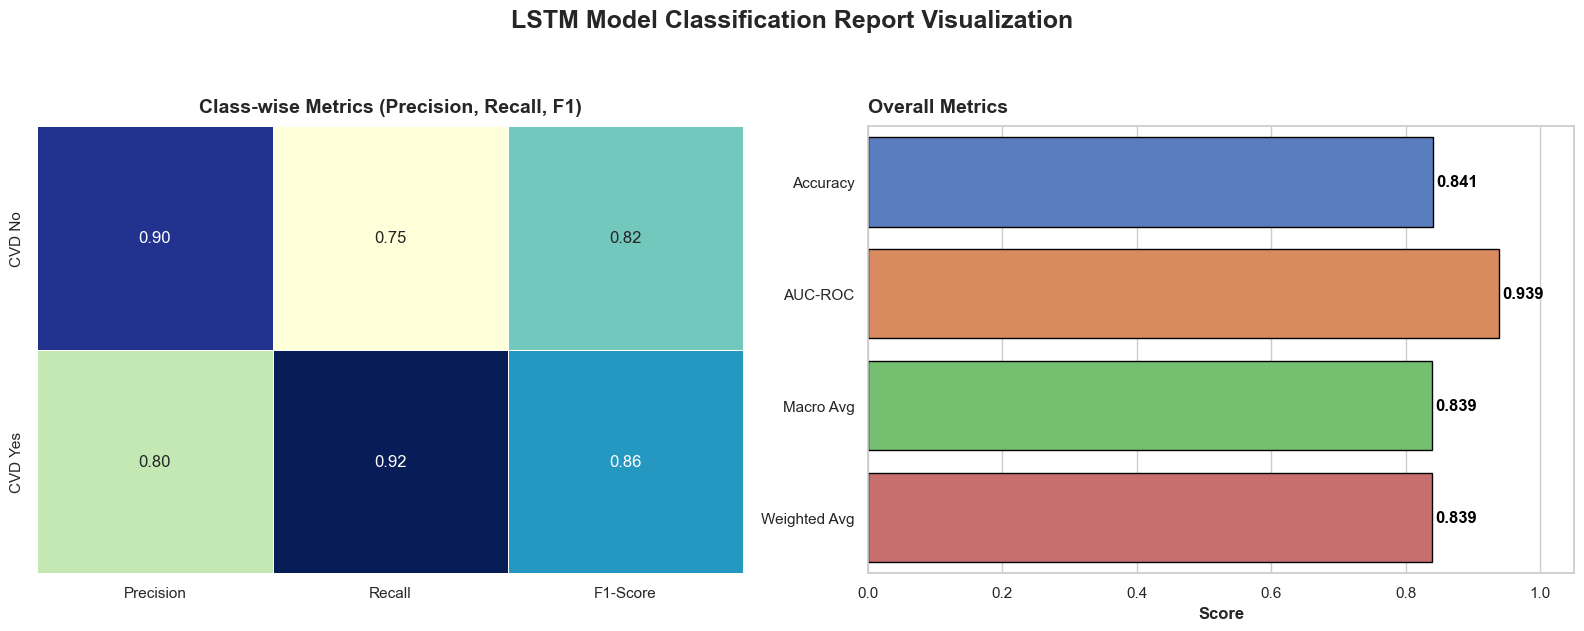

In [39]:
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 6: Assuming you already have X_test_lstm, y_test, and best_LSTM_model
# Predict probabilities
y_pred_prob = best_LSTM_model.predict(X_test_lstm)

# Convert probabilities to class labels using threshold 0.5
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_prob)


# Extract metrics from classification report to dict for visualization
report_dict = classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes'], output_dict=True)

# Prepare class-wise metrics DataFrame
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [report_dict['CVD No']['precision'], report_dict['CVD Yes']['precision']],
    'Recall': [report_dict['CVD No']['recall'], report_dict['CVD Yes']['recall']],
    'F1-Score': [report_dict['CVD No']['f1-score'], report_dict['CVD Yes']['f1-score']]
}
class_df = pd.DataFrame(metrics_data)

# Prepare overall metrics DataFrame, add AUC-ROC to it
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [
        report_dict['accuracy'],
        auc_roc,
        report_dict['macro avg']['f1-score'],
        report_dict['weighted avg']['f1-score']
    ]
}
overall_df = pd.DataFrame(overall_metrics)

# Set seaborn style
sns.set(style="whitegrid")

# Plot visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.suptitle("LSTM Model Classification Report Visualization", fontsize=18, fontweight='bold', y=1.05)

# Heatmap for class-wise metrics
sns.heatmap(class_df.set_index('Class'), annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, ax=ax1, cbar=False)
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Bar chart for overall metrics
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2, edgecolor='black')
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.3f}", color='black', va='center', fontweight='bold', fontsize=12)
ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics', fontsize=14, fontweight='bold', pad=10, loc='left')
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


#### Ploting Confussion Matrics

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
Classification Report:
               precision    recall  f1-score   support

      CVD No       0.90      0.75      0.82      2044
     CVD Yes       0.80      0.92      0.86      2142

    accuracy                           0.84      4186
   macro avg       0.85      0.84      0.84      4186
weighted avg       0.85      0.84      0.84      4186



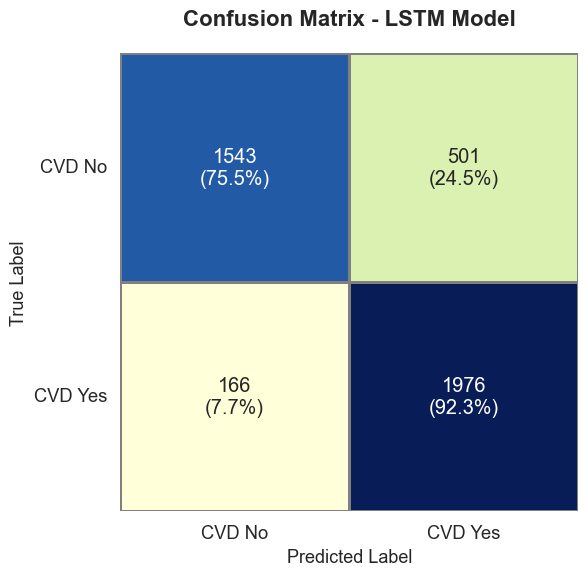

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities
y_pred_prob = best_LSTM_model.predict(X_test_lstm)

# Convert to class labels
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
report = classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes'])
print("Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Labels for display
labels = ['CVD No', 'CVD Yes']

# Plotting the enhanced heatmap
plt.figure(figsize=(9, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Annotate with both count and percentage
annot = np.array([["{0}\n({1:.1%})".format(count, percent) 
                   for count, percent in zip(row, cm_percent_row)] 
                   for row, cm_percent_row in zip(cm, cm_percent)])

sns.heatmap(cm, 
            annot=annot, 
            fmt='', 
            cmap='YlGnBu', 
            xticklabels=labels, 
            yticklabels=labels,
            linewidths=1, 
            linecolor='gray', 
            cbar=False, 
            square=True)

plt.title('Confusion Matrix - LSTM Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

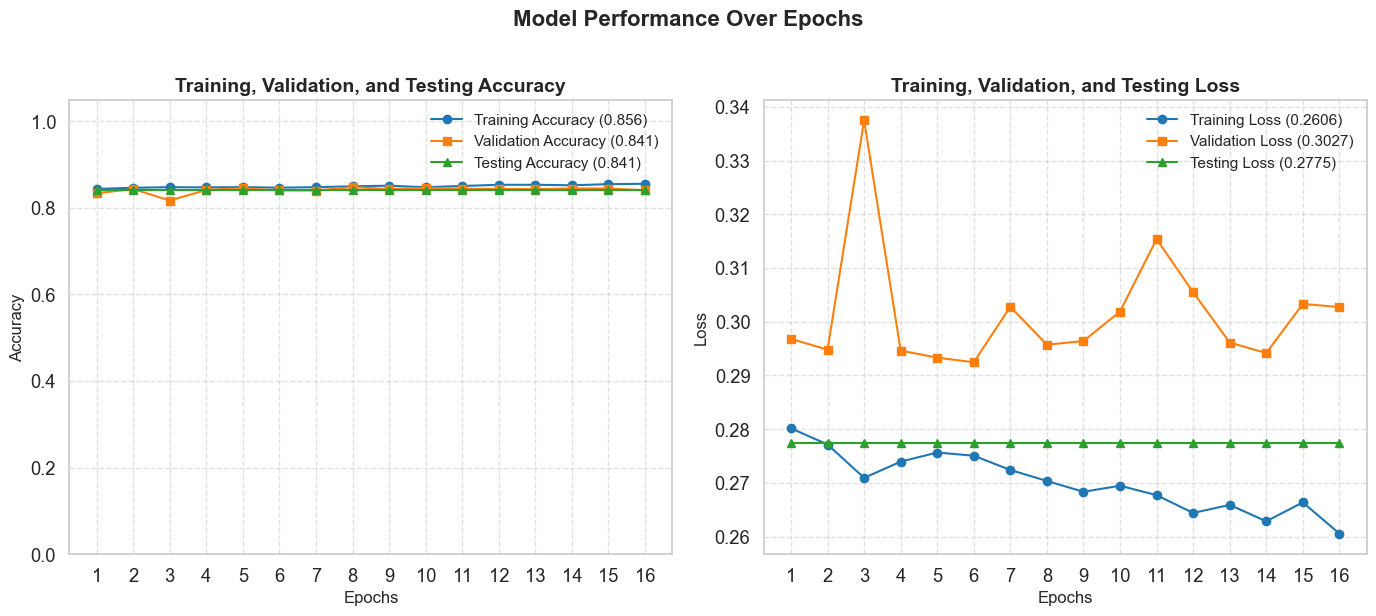

In [165]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Calculate Testing Accuracy per Epoch ===
test_accuracies = []
test_losses = []

for epoch in range(len(history.history['accuracy'])):
    test_loss, test_acc = best_LSTM_model.evaluate(X_test_lstm, y_test, verbose=0)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

# === Step 2: Extract training and validation values ===
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# === Final values for annotation or legend ===
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_test_acc = test_accuracies[-1]

final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]
final_test_loss = test_losses[-1]

# === Step 3: Plot Subplots for Accuracy and Loss ===
plt.figure(figsize=(14, 6))

# --- Subplot 1: Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label=f'Training Accuracy ({final_train_acc:.3f})', marker='o', color='#1f77b4')
plt.plot(epochs, val_acc, label=f'Validation Accuracy ({final_val_acc:.3f})', marker='s', color='#ff7f0e')
plt.plot(epochs, test_accuracies, label=f'Testing Accuracy ({final_test_acc:.3f})', marker='^', color='#2ca02c')
plt.title('Training, Validation, and Testing Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epochs)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, frameon=False)

# --- Subplot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label=f'Training Loss ({final_train_loss:.4f})', marker='o', color='#1f77b4')
plt.plot(epochs, val_loss, label=f'Validation Loss ({final_val_loss:.4f})', marker='s', color='#ff7f0e')
plt.plot(epochs, test_losses, label=f'Testing Loss ({final_test_loss:.4f})', marker='^', color='#2ca02c')
plt.title('Training, Validation, and Testing Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, frameon=False)

# === Final layout ===
plt.suptitle('Model Performance Over Epochs', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


#### Model Interpretation Using LIME

X_train_lstm shape: (16740, 1, 26)
X_test_lstm shape: (4186, 1, 26)
Mismatch: using auto-generated names for 26 features.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


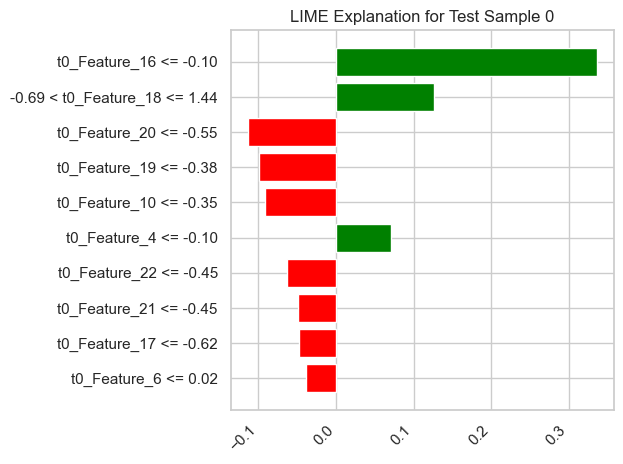

Top contributing features:
t0_Feature_16 <= -0.10: 0.3358
-0.69 < t0_Feature_18 <= 1.44: 0.1257
t0_Feature_20 <= -0.55: -0.1130
t0_Feature_19 <= -0.38: -0.0994
t0_Feature_10 <= -0.35: -0.0920
t0_Feature_4 <= -0.10: 0.0714
t0_Feature_22 <= -0.45: -0.0631
t0_Feature_21 <= -0.45: -0.0494
t0_Feature_17 <= -0.62: -0.0473
t0_Feature_6 <= 0.02: -0.0389


In [74]:
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Step 1: Check LSTM input shape
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

# Step 2: Try your original feature names
original_feature_names = ['Age', 'Pulse Rate', 'Systolic Pressure', 'Diastolic Pressure',
       'Respiratory Rate', 'Temperature ', 'Weight', 'BMI',
       'Total Cholesterol ', 'Risk Factor_Dyslamapedia',
       'Risk Factor_Hypertension', 'Risk Factor_Obesity', 'Risk Factor_Stress',
       'Allr Hx_YES', 'Gender_Male', 'Medic Hx_Yes', 'Historian_Yes',
       'Musculoskeletal System_Yes', 'Diagnosis_Endocrine Disorders',
       'Diagnosis_Infectious Diseases', 'Diagnosis_Surgical Conditions',
       'Medical Condition_Asthma', 'Medical Condition_Cancer',
       'Medical Condition_Diabetes', 'Medical Condition_Hypertension',
       'Medical Condition_Obesity', 'CVD_Yes']

# Step 3: Validate or replace feature names
n_features = X_train_lstm.shape[2]
if len(original_feature_names) != n_features:
    print(f"Mismatch: using auto-generated names for {n_features} features.")
    original_feature_names = [f"Feature_{i}" for i in range(n_features)]

# Step 4: Generate timestep-based feature names
feature_names = [f"t{t}_{original_feature_names[f]}" for t in range(X_train_lstm.shape[1]) for f in range(n_features)]

# Step 5: Flatten 3D input to 2D for LIME
X_train_flat = X_train_lstm.reshape(X_train_lstm.shape[0], -1)
X_test_flat = X_test_lstm.reshape(X_test_lstm.shape[0], -1)

# Step 6: Prediction function (reshape back to 3D)
def predict_fn(X_flat):
    X_reshaped = X_flat.reshape((-1, X_train_lstm.shape[1], X_train_lstm.shape[2]))
    preds = best_LSTM_model.predict(X_reshaped)
    return np.hstack([1 - preds, preds])  # binary classification

# Step 7: Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_flat,
    feature_names=feature_names,
    class_names=['Class 0', 'Class 1'],
    discretize_continuous=True
)

# Step 8: Explain one test instance
i = 0
exp = explainer.explain_instance(
    X_test_flat[i],
    predict_fn,
    num_features=10,
    top_labels=1
)

# Step 9: Visualize the explanation
label = exp.available_labels()[0]
fig = exp.as_pyplot_figure(label=label)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title(f"LIME Explanation for Test Sample {i}")
plt.show()

# Optional: print feature importances
print("Top contributing features:")
for feature, weight in exp.as_list(label=label):
    print(f"{feature}: {weight:.4f}")


In [ ]:
selected_features = [
    'Medic Hx_Yes',                # index 16
    'Musculoskeletal System_Yes',  # index 18
    'Diagnosis_Infectious Diseases', # index 20
    'Diagnosis_Endocrine Disorders', # index 19
    'Risk Factor_Hypertension',    # index 10
    'Respiratory Rate',            # index 4
    'Medical Condition_Cancer',    # index 22
    'Diagnosis_Surgical Conditions', # index 21
    'Historian_Yes',               # index 17
    'Weight'                       # index 6
]

#### 2. Auto Encoder

In [96]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------
# ✅ Load and preprocess data
# ----------------------------
data = pd.read_csv("scaled_CVD_Dataset.csv")
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)

# 🔹 Exclude the target column (assumed to be the last column)
X = data.iloc[:, :-1].values.astype(np.float32)  # Features only
y = data.iloc[:, -1].values.astype(int)          # Target (not used in autoencoder)

# -----------------------
# ✅ Split train/test data
# -----------------------
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# ---------------------------------
# ✅ Optuna Objective Function
# ---------------------------------
def objective(trial):
    # Suggest hyperparameters
    encoding_dim = trial.suggest_int('encoding_dim', 8, 64)
    hidden_dim1 = trial.suggest_int('hidden_dim1', 64, 128)
    hidden_dim2 = trial.suggest_int('hidden_dim2', encoding_dim + 4, hidden_dim1)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = 50

    input_dim = X_train.shape[1]

    # Build autoencoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(hidden_dim1, activation=activation)(input_layer)
    encoded = Dense(hidden_dim2, activation=activation)(encoded)
    encoded_output = Dense(encoding_dim, activation=activation)(encoded)

    decoded = Dense(hidden_dim2, activation=activation)(encoded_output)
    decoded = Dense(hidden_dim1, activation=activation)(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=tf.keras.optimizers.get({
        'class_name': optimizer,
        'config': {'learning_rate': learning_rate}
    }), loss='mse', metrics=['mae'])

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_test, X_test),
        verbose=0,
        callbacks=[es]
    )

    # Evaluate
    val_preds = autoencoder.predict(X_test)
    mse = mean_squared_error(X_test, val_preds)
    return mse

# -----------------------------
# ✅ Run Optuna Optimization
# -----------------------------
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("\n🎯 Best hyperparameters:")
print(study.best_params)

# -----------------------------
# ✅ Retrain with best params
# -----------------------------
params = study.best_params
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(params['hidden_dim1'], activation=params['activation'])(input_layer)
encoded = Dense(params['hidden_dim2'], activation=params['activation'])(encoded)
encoded_output = Dense(params['encoding_dim'], activation=params['activation'])(encoded)

decoded = Dense(params['hidden_dim2'], activation=params['activation'])(encoded_output)
decoded = Dense(params['hidden_dim1'], activation=params['activation'])(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

best_model_auto = Model(inputs=input_layer, outputs=output_layer)
best_model_auto.compile(optimizer=tf.keras.optimizers.get({
    'class_name': params['optimizer'],
    'config': {'learning_rate': params['learning_rate']}
}), loss='mse', metrics=['mae'])

history = best_model_auto.fit(
    X_train, X_train,
    epochs=50,
    batch_size=params['batch_size'],
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# -----------------------------
# ✅ Final Evaluation
# -----------------------------
reconstructed = best_model_auto.predict(X_test)
mse = mean_squared_error(X_test, reconstructed)
mae = mean_absolute_error(X_test, reconstructed)

print(f"\n📊 Autoencoder Final Evaluation on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")


[I 2025-05-21 12:43:10,751] A new study created in memory with name: no-name-fca122fc-6584-48d9-86ea-e703aa056f8b


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-21 12:43:22,700] Trial 0 finished with value: 0.05832356587052345 and parameters: {'encoding_dim': 33, 'hidden_dim1': 87, 'hidden_dim2': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.006434443822042683, 'batch_size': 32}. Best is trial 0 with value: 0.05832356587052345.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-21 12:43:40,364] Trial 1 finished with value: 0.03281668573617935 and parameters: {'encoding_dim': 43, 'hidden_dim1': 78, 'hidden_dim2': 47, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0037060547283298867, 'batch_size': 16}. Best is trial 1 with value: 0.03281668573617935.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-21 12:43:58,007] Trial 2 finished with value: 0.010733203031122684 and parameters: {'encoding_dim': 31, 'hidden_dim1': 88, 'hidden_dim2': 39, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0006197324175025787, 'batch_size': 64}. Best is trial 2 with value: 0.010733203031122684.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-21 12:44:10,615] Trial 3 finished with value: 0.1071842834353447 and parameters: {'encoding_dim': 15, 'hidden_dim1': 118, 'hidden_dim2': 112, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.004657986037113432, 'batch_size': 32}. Best is trial 2 with value: 0.010733203031122684.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-21 12:45:26,460] Trial 4 finished with value: 0.005094868130981922 and parameters: {'encoding_dim': 39, 'hidden_dim1': 120, 'hidden_dim2': 90, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 3.267528434273027e-05, 'batch_size': 16}. Best is trial 4 with value: 0.005094868130981922.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-21 12:45:39,926] Trial 5 finished with value: 0.013898953795433044 and parameters: {'encoding_dim': 46, 'hidden_dim1': 72, 'hidden_dim2': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004347560348187199, 'batch_size': 32}. Best is trial 4 with value: 0.005094868130981922.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-21 12:46:54,139] Trial 6 finished with value: 0.17875459790229797 and parameters: {'encoding_dim': 11, 'hidden_dim1': 68, 'hidden_dim2': 45, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 5.474479606922473e-05, 'batch_size': 16}. Best is trial 4 with value: 0.005094868130981922.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-21 12:47:40,566] Trial 7 finished with value: 0.002938073594123125 and parameters: {'encoding_dim': 28, 'hidden_dim1': 82, 'hidden_dim2': 56, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001048185945370163, 'batch_size': 32}. Best is trial 7 with value: 0.002938073594123125.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:49:10,372] Trial 8 finished with value: 0.07044749706983566 and parameters: {'encoding_dim': 20, 'hidden_dim1': 126, 'hidden_dim2': 66, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 2.5651725725544183e-05, 'batch_size': 16}. Best is trial 7 with value: 0.002938073594123125.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-21 12:50:17,835] Trial 9 finished with value: 0.0037050843238830566 and parameters: {'encoding_dim': 31, 'hidden_dim1': 99, 'hidden_dim2': 57, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00034470695539033446, 'batch_size': 16}. Best is trial 7 with value: 0.002938073594123125.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-21 12:50:48,427] Trial 10 finished with value: 0.02337542362511158 and parameters: {'encoding_dim': 25, 'hidden_dim1': 105, 'hidden_dim2': 29, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.000113795924096045, 'batch_size': 64}. Best is trial 7 with value: 0.002938073594123125.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-21 12:51:19,708] Trial 11 finished with value: 0.0049057090654969215 and parameters: {'encoding_dim': 60, 'hidden_dim1': 101, 'hidden_dim2': 72, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00039983877595946873, 'batch_size': 32}. Best is trial 7 with value: 0.002938073594123125.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-21 12:52:56,624] Trial 12 finished with value: 0.003151463810354471 and parameters: {'encoding_dim': 53, 'hidden_dim1': 89, 'hidden_dim2': 62, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00015462320757494665, 'batch_size': 16}. Best is trial 7 with value: 0.002938073594123125.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:53:51,298] Trial 13 finished with value: 0.007612072862684727 and parameters: {'encoding_dim': 57, 'hidden_dim1': 84, 'hidden_dim2': 65, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00010582399881751603, 'batch_size': 32}. Best is trial 7 with value: 0.002938073594123125.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:54:03,713] Trial 14 finished with value: 0.002908143913373351 and parameters: {'encoding_dim': 48, 'hidden_dim1': 90, 'hidden_dim2': 60, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0012256452513150146, 'batch_size': 64}. Best is trial 14 with value: 0.002908143913373351.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:54:35,976] Trial 15 finished with value: 0.27979302406311035 and parameters: {'encoding_dim': 53, 'hidden_dim1': 64, 'hidden_dim2': 59, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 1.0160047402181074e-05, 'batch_size': 64}. Best is trial 14 with value: 0.002908143913373351.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:54:57,537] Trial 16 finished with value: 0.0010735520627349615 and parameters: {'encoding_dim': 45, 'hidden_dim1': 109, 'hidden_dim2': 81, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0012334081940486863, 'batch_size': 64}. Best is trial 16 with value: 0.0010735520627349615.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:55:17,745] Trial 17 finished with value: 0.0018544744234532118 and parameters: {'encoding_dim': 46, 'hidden_dim1': 110, 'hidden_dim2': 92, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0011255749983532619, 'batch_size': 64}. Best is trial 16 with value: 0.0010735520627349615.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:55:28,088] Trial 18 finished with value: 0.028029929846525192 and parameters: {'encoding_dim': 39, 'hidden_dim1': 109, 'hidden_dim2': 96, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0017432963678005397, 'batch_size': 64}. Best is trial 16 with value: 0.0010735520627349615.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-21 12:55:48,698] Trial 19 finished with value: 0.0012865046737715602 and parameters: {'encoding_dim': 62, 'hidden_dim1': 112, 'hidden_dim2': 99, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0012678065561374612, 'batch_size': 64}. Best is trial 16 with value: 0.0010735520627349615.



🎯 Best hyperparameters:
{'encoding_dim': 45, 'hidden_dim1': 109, 'hidden_dim2': 81, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0012334081940486863, 'batch_size': 64}
Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5395 - mae: 0.5024 - val_loss: 0.0784 - val_mae: 0.2088
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0601 - mae: 0.1813 - val_loss: 0.0371 - val_mae: 0.1427
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0300 - mae: 0.1280 - val_loss: 0.0212 - val_mae: 0.1073
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - mae: 0.1003 - val_loss: 0.0175 - val_mae: 0.0965
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - mae: 0.0922 - val_loss: 0.0296 - val_mae: 0.1309
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0209 - mae: 0.1013 - val_loss: 0.0109 - val_mae: 0.0763
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100 - mae: 0.0735 - val_loss: 0.0075 - val_

#### Plot training & validation loss values

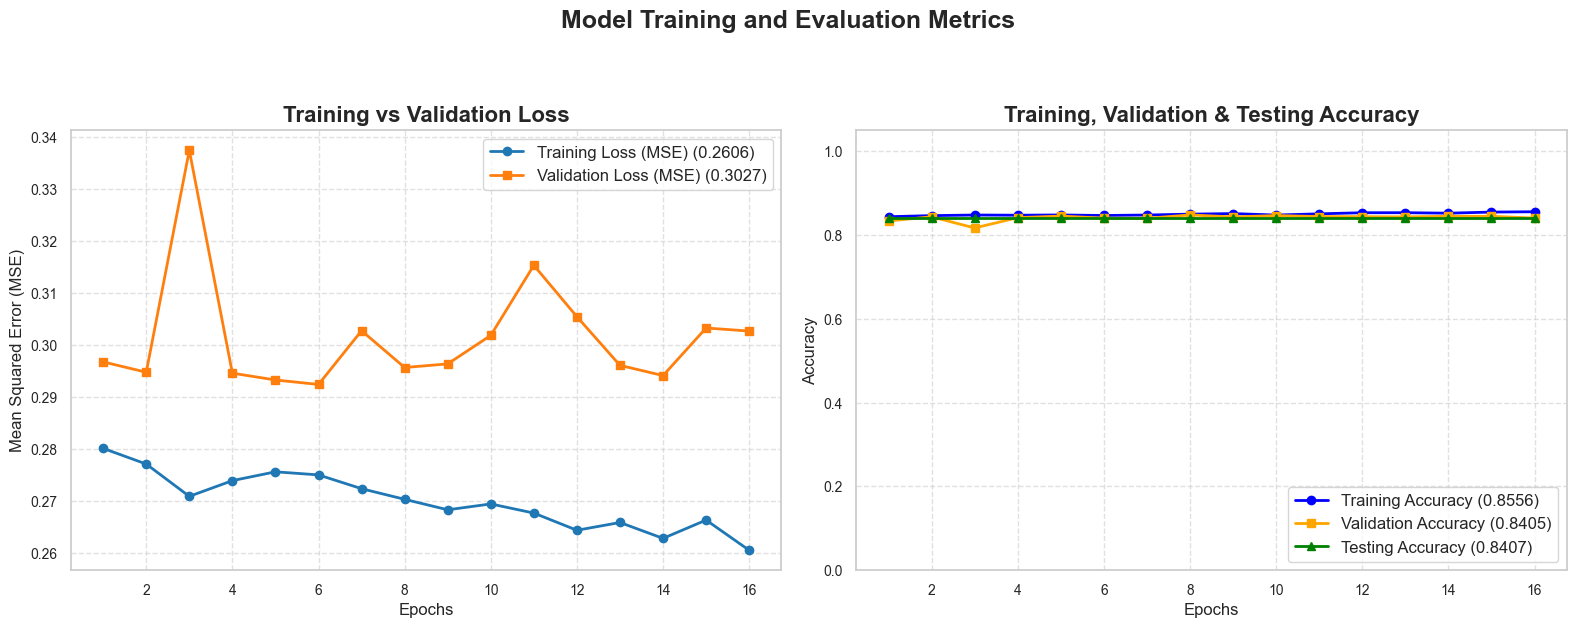

In [158]:
import matplotlib.pyplot as plt

# Extract final loss values
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Extract final accuracy values
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

# If you have test accuracies per epoch saved in test_accuracies list, get last value
final_test_acc = test_accuracies[-1] if 'test_accuracies' in globals() else None

epochs = range(1, len(history.history['loss']) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss subplot
ax1.plot(epochs, history.history['loss'], 
         label=f'Training Loss (MSE) ({final_train_loss:.4f})', 
         color='#1f77b4', linewidth=2, marker='o')
ax1.plot(epochs, history.history['val_loss'], 
         label=f'Validation Loss (MSE) ({final_val_loss:.4f})', 
         color='#ff7f0e', linewidth=2, marker='s')

ax1.set_title('Training vs Validation Loss', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', labelsize=10)

# Plot Accuracy subplot
ax2.plot(epochs, history.history['accuracy'], 
         label=f'Training Accuracy ({final_train_acc:.4f})', 
         color='blue', linewidth=2, marker='o')
ax2.plot(epochs, history.history['val_accuracy'], 
         label=f'Validation Accuracy ({final_val_acc:.4f})', 
         color='orange', linewidth=2, marker='s')

if final_test_acc is not None:
    ax2.plot(epochs, test_accuracies, 
             label=f'Testing Accuracy ({final_test_acc:.4f})', 
             color='green', linewidth=2, marker='^')

ax2.set_title('Training, Validation & Testing Accuracy', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_ylim(0, 1.05)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=12, loc='lower right')
ax2.tick_params(axis='both', labelsize=10)

# Overall title
fig.suptitle('Model Training and Evaluation Metrics', fontsize=18, fontweight='bold', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()

#### Import the Model

In [78]:
from tensorflow.keras.models import Model

# Extract the encoder from the trained autoencoder
encoder = Model(inputs=best_model_auto.input, outputs=best_model_auto.get_layer(index=3).output)


#### # Get encoded features

In [79]:
# Get encoded features
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


#### Compile and Fit the model

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

dnn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dnn.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_data=(X_test_encoded, y_test), verbose=1)


Epoch 1/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6912 - loss: 0.5715 - val_accuracy: 0.7893 - val_loss: 0.3744
Epoch 2/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7883 - loss: 0.3852 - val_accuracy: 0.8029 - val_loss: 0.3734
Epoch 3/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7923 - loss: 0.3726 - val_accuracy: 0.8046 - val_loss: 0.3739
Epoch 4/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7989 - loss: 0.3632 - val_accuracy: 0.8053 - val_loss: 0.3449
Epoch 5/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8015 - loss: 0.3508 - val_accuracy: 0.8079 - val_loss: 0.3485
Epoch 6/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8074 - loss: 0.3453 - val_accuracy: 0.8137 - val_loss: 0.3333
Epoch 7/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8142 - loss: 0.3355 - val_accuracy: 0.8244 - val_loss: 0.3235
Epoch 8/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8149 - loss: 0.3299 - val_accuracy: 0.

#### Classification Report

In [84]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Predict probabilities on test set
y_pred_probs = dnn.predict(X_test_encoded)

# Step 2: Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Step 3: Generate classification report with custom class names
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["CVD No", "CVD Yes"], digits=4))


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step

📋 Classification Report:
              precision    recall  f1-score   support

      CVD No     0.8715    0.7734    0.8195      2034
     CVD Yes     0.8064    0.8922    0.8471      2152

    accuracy                         0.8344      4186
   macro avg     0.8389    0.8328    0.8333      4186
weighted avg     0.8380    0.8344    0.8337      4186



#### Visualizing Classification Report

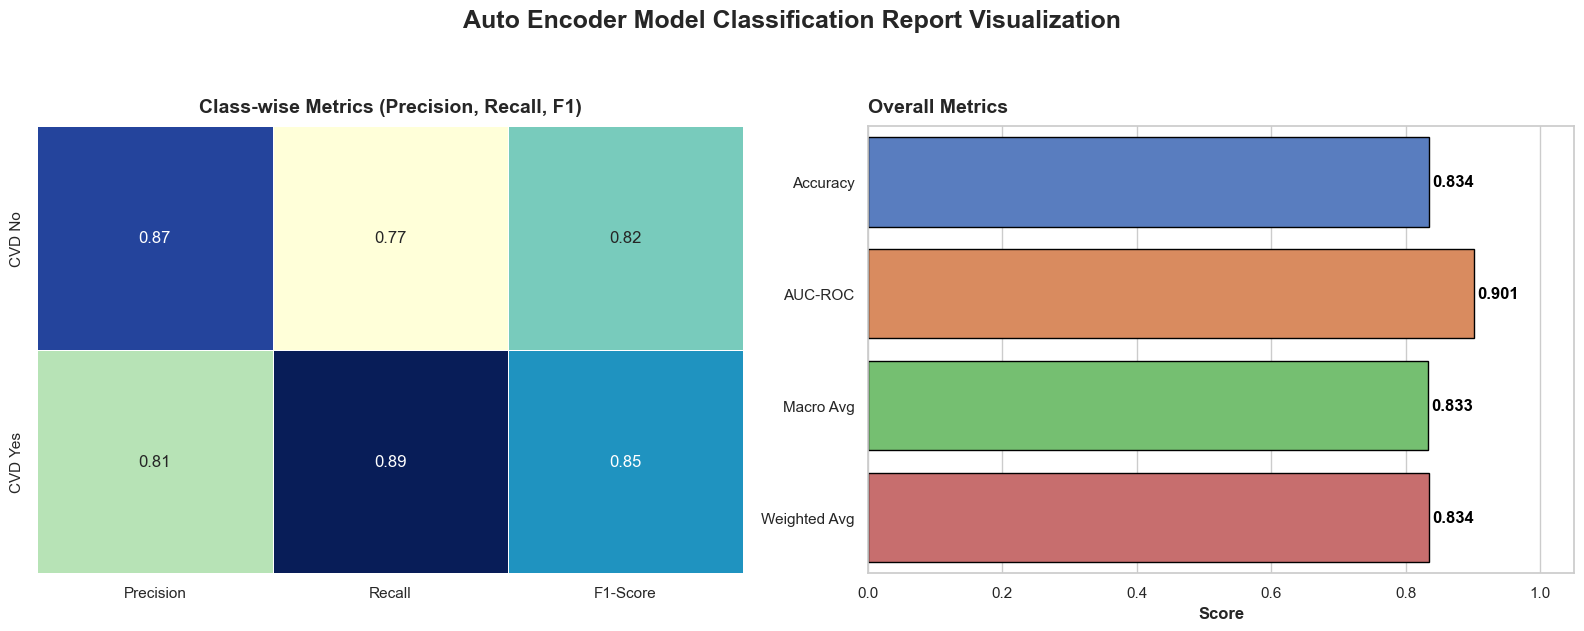

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from classification report
report_dict = {
    'CVD No': {'precision': 0.8715, 'recall': 0.7734, 'f1-score': 0.8195},
    'CVD Yes': {'precision': 0.8064, 'recall': 0.8922, 'f1-score': 0.8471},
    'accuracy': 0.8344,
    'macro avg': {'f1-score': 0.8333},
    'weighted avg': {'f1-score': 0.8337}
}
auc_roc = 0.9007  # Given AUC-ROC value

# Prepare class-wise metrics DataFrame
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [report_dict['CVD No']['precision'], report_dict['CVD Yes']['precision']],
    'Recall': [report_dict['CVD No']['recall'], report_dict['CVD Yes']['recall']],
    'F1-Score': [report_dict['CVD No']['f1-score'], report_dict['CVD Yes']['f1-score']]
}
class_df = pd.DataFrame(metrics_data)

# Prepare overall metrics DataFrame
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg', 'Weighted Avg'],
    'Score': [
        report_dict['accuracy'],
        auc_roc,
        report_dict['macro avg']['f1-score'],
        report_dict['weighted avg']['f1-score']
    ]
}
overall_df = pd.DataFrame(overall_metrics)

# Set seaborn style
sns.set(style="whitegrid")

# Plot visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.suptitle("Auto Encoder Model Classification Report Visualization", fontsize=18, fontweight='bold', y=1.05)

# Heatmap for class-wise metrics
sns.heatmap(class_df.set_index('Class'), annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, ax=ax1, cbar=False)
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Bar chart for overall metrics
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2, edgecolor='black')
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.005, i, f"{row.Score:.3f}", color='black', va='center', fontweight='bold', fontsize=12)
ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics', fontsize=14, fontweight='bold', pad=10, loc='left')
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


#### Ploting Confussion Matrics

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
Classification Report:
               precision    recall  f1-score   support

      CVD No       0.87      0.77      0.82      2034
     CVD Yes       0.81      0.89      0.85      2152

    accuracy                           0.83      4186
   macro avg       0.84      0.83      0.83      4186
weighted avg       0.84      0.83      0.83      4186



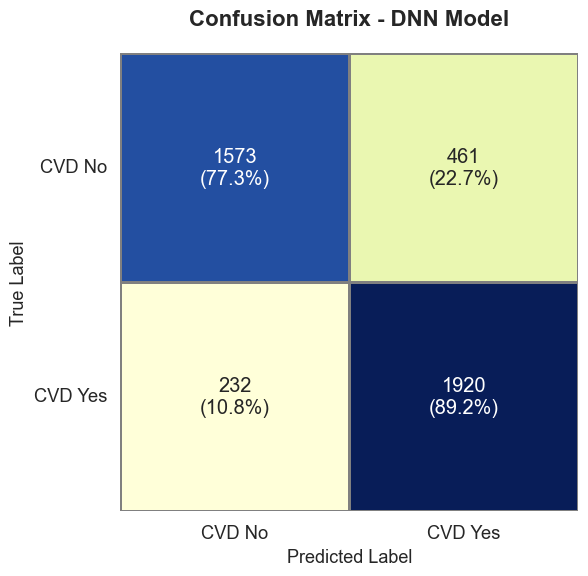

In [88]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities on test set
y_pred_probs = dnn.predict(X_test_encoded)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Print classification report
report = classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes'])
print("Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages per true label (row-wise)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Labels for the plot
labels = ['CVD No', 'CVD Yes']

# Prepare annotation labels with counts and percentages
annot = np.array([["{0}\n({1:.1%})".format(count, percent) 
                   for count, percent in zip(row, cm_percent_row)] 
                  for row, cm_percent_row in zip(cm, cm_percent)])

# Plot heatmap
plt.figure(figsize=(9, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

sns.heatmap(cm, 
            annot=annot, 
            fmt='', 
            cmap='YlGnBu', 
            xticklabels=labels, 
            yticklabels=labels,
            linewidths=1, 
            linecolor='gray', 
            cbar=False, 
            square=True)

plt.title('Confusion Matrix - DNN Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

In [99]:
history_dnn = dnn.fit(
    X_train_encoded, y_train,
    validation_data=(X_test_encoded, y_test),
    epochs=50,      # set number of epochs you want
    batch_size=32,  # adjust batch size as needed
    verbose=1
)


Epoch 1/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8508 - loss: 0.2671 - val_accuracy: 0.8261 - val_loss: 0.2974
Epoch 2/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8549 - loss: 0.2655 - val_accuracy: 0.8383 - val_loss: 0.2803
Epoch 3/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8483 - loss: 0.2669 - val_accuracy: 0.8383 - val_loss: 0.2800
Epoch 4/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8556 - loss: 0.2686 - val_accuracy: 0.8373 - val_loss: 0.2909
Epoch 5/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8504 - loss: 0.2738 - val_accuracy: 0.8373 - val_loss: 0.2847
Epoch 6/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8499 - loss: 0.2711 - val_accuracy: 0.8356 - val_loss: 0.2833
Epoch 7/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8552 - loss: 0.2618 - val_accuracy: 0.8313 - val_loss: 0.2923
Epoch 8/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8484 - loss: 0.2635 - val_accuracy: 0.

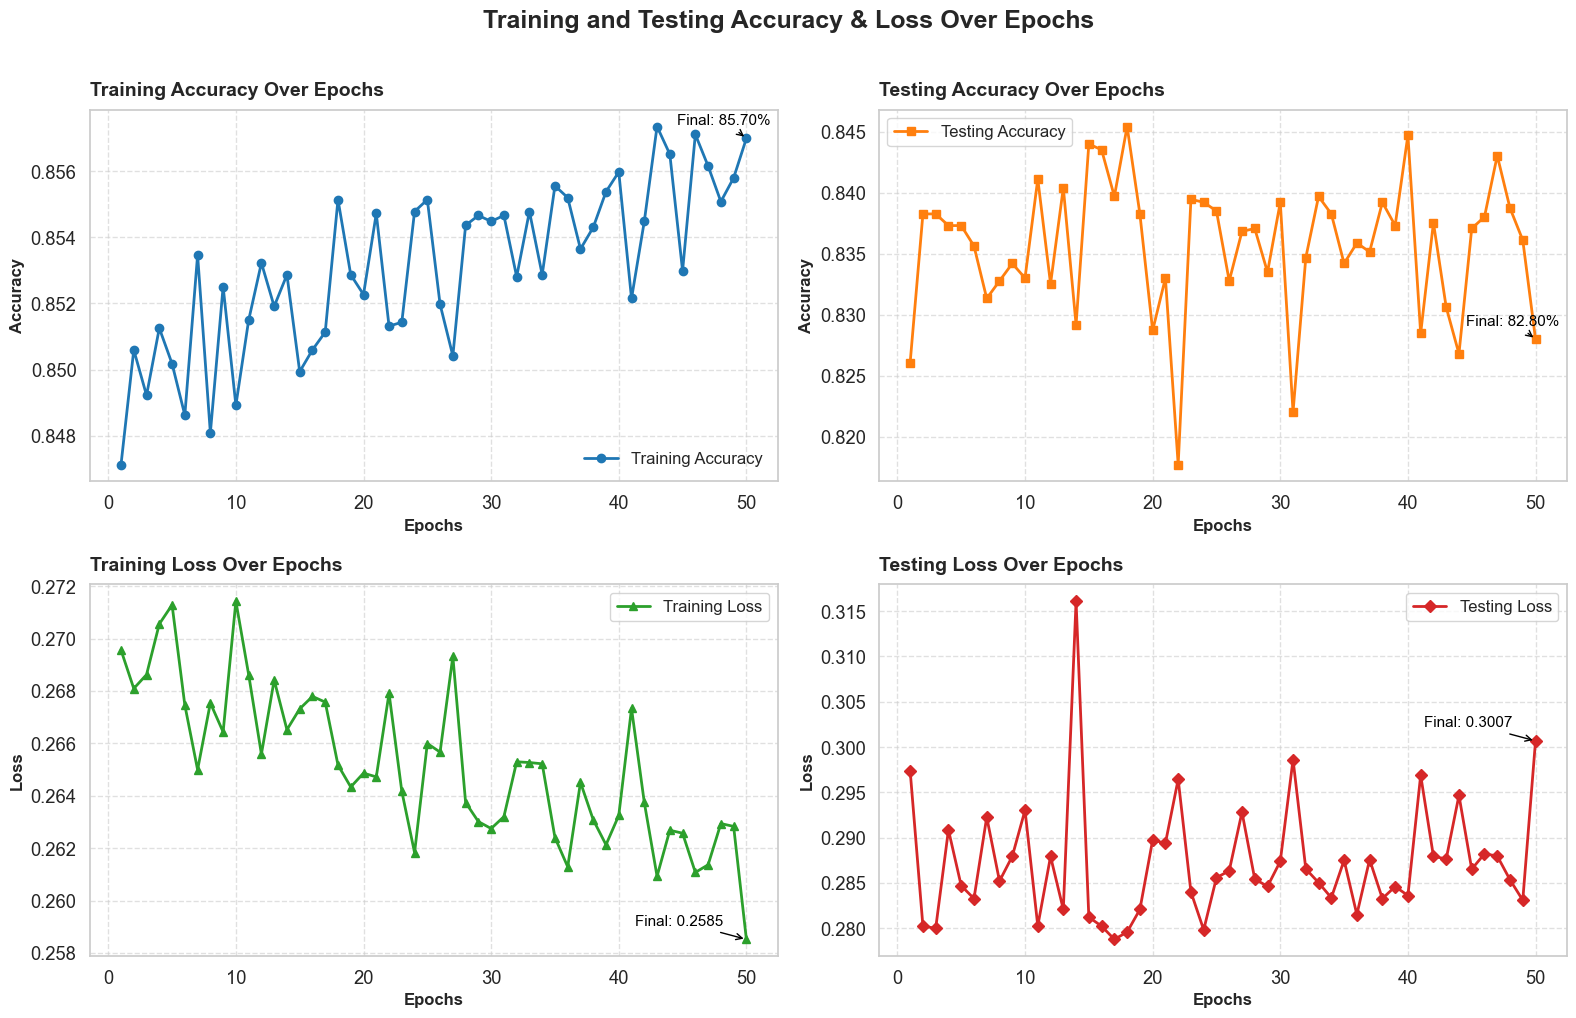

In [160]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history_dnn.history['accuracy']
test_acc = history_dnn.history['val_accuracy']
train_loss = history_dnn.history['loss']
test_loss = history_dnn.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Get final values
final_train_acc = train_acc[-1]
final_test_acc = test_acc[-1]
final_train_loss = train_loss[-1]
final_test_loss = test_loss[-1]

plt.figure(figsize=(16, 10))

# --- Subplot 1: Training Accuracy ---
plt.subplot(2, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', color='#1f77b4', linewidth=2, marker='o')
plt.title('Training Accuracy Over Epochs', fontsize=14, fontweight='bold', pad=10, loc='left')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='lower right', frameon=False)
plt.annotate(f'Final: {final_train_acc:.2%}', 
             xy=(epochs[-1], final_train_acc), 
             xytext=(-50, 10), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='black')

# --- Subplot 2: Testing Accuracy ---
plt.subplot(2, 2, 2)
plt.plot(epochs, test_acc, label='Testing Accuracy', color='#ff7f0e', linewidth=2, marker='s')
plt.title('Testing Accuracy Over Epochs', fontsize=14, fontweight='bold', pad=10, loc='left')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.annotate(f'Final: {final_test_acc:.2%}', 
             xy=(epochs[-1], final_test_acc), 
             xytext=(-50, 10), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='black')

# --- Subplot 3: Training Loss ---
plt.subplot(2, 2, 3)
plt.plot(epochs, train_loss, label='Training Loss', color='#2ca02c', linewidth=2, marker='^')  # Green
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold', pad=10, loc='left')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper right')
plt.annotate(f'Final: {final_train_loss:.4f}', 
             xy=(epochs[-1], final_train_loss), 
             xytext=(-80, 10), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='black')

# --- Subplot 4: Testing Loss ---
plt.subplot(2, 2, 4)
plt.plot(epochs, test_loss, label='Testing Loss', color='#d62728', linewidth=2, marker='D')  # Red
plt.title('Testing Loss Over Epochs', fontsize=14, fontweight='bold', pad=10, loc='left')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.annotate(f'Final: {final_test_loss:.4f}', 
             xy=(epochs[-1], final_test_loss), 
             xytext=(-80, 10), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='black')

# Common super title
plt.suptitle('Training and Testing Accuracy & Loss Over Epochs', fontsize=18, fontweight='bold', y=1.02)

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Space for suptitle
plt.show()


#### SHAP Interpretability (for DNN Auto Encoder)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step


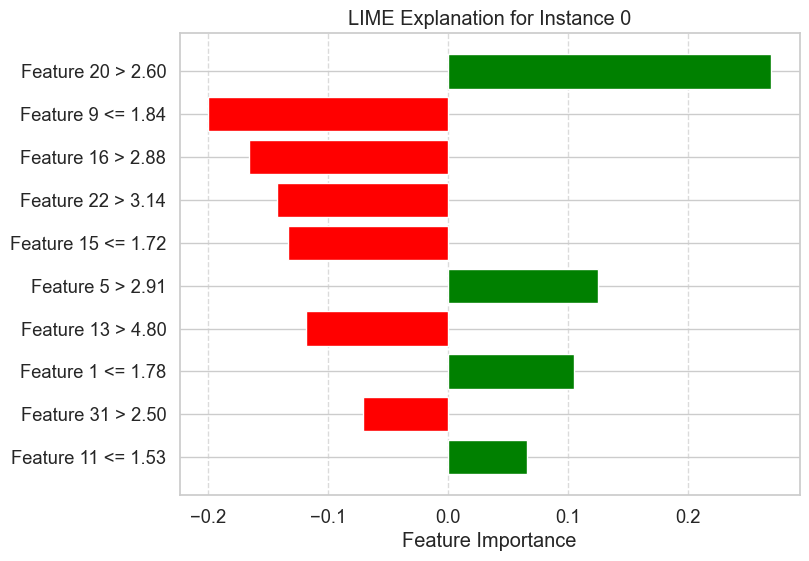

In [121]:
import lime
import lime.lime_tabular
import numpy as np

# Use the first 100 samples for explanation
X_sample = X_test_encoded[:100]

# Define class names
class_names = ['CVD No', 'CVD Yes']

# Fix: Define predict_proba_fn to wrap the DNN output correctly
def predict_proba_fn(x):
    probs = dnn.predict(x)  # shape: (n_samples, 1)
    return np.hstack([(1 - probs), probs])  # shape: (n_samples, 2)

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_encoded),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Explain a single instance (e.g., index 0)
i = 0
exp = explainer.explain_instance(
    data_row=X_sample[i],
    predict_fn=predict_proba_fn,
    num_features=10
)
# Visualize the explanation
import matplotlib.pyplot as plt

# Get the explanation as a list of (feature, weight) tuples
exp_list = exp.as_list(label=1)  # assuming class 1 ("CVD Yes")

# Separate features and weights
features = [item[0] for item in exp_list]
weights = [item[1] for item in exp_list]

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
colors = ['green' if w > 0 else 'red' for w in weights]  # positive green, negative red
plt.barh(features, weights, color=colors)
plt.xlabel('Feature Importance')
plt.title('LIME Explanation for Instance {}'.format(i))
plt.gca().invert_yaxis()  # Highest importance on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [127]:
# Your original feature names
original_feature_names = ['Age', 'Pulse Rate', 'Systolic Pressure', 'Diastolic Pressure',
       'Respiratory Rate', 'Temperature ', 'Weight', 'BMI',
       'Total Cholesterol ', 'Risk Factor_Dyslamapedia',
       'Risk Factor_Hypertension', 'Risk Factor_Obesity', 'Risk Factor_Stress',
       'Allr Hx_YES', 'Gender_Male', 'Medic Hx_Yes', 'Historian_Yes',
       'Musculoskeletal System_Yes', 'Diagnosis_Endocrine Disorders',
       'Diagnosis_Infectious Diseases', 'Diagnosis_Surgical Conditions',
       'Medical Condition_Asthma', 'Medical Condition_Cancer',
       'Medical Condition_Diabetes', 'Medical Condition_Hypertension',
       'Medical Condition_Obesity', 'CVD_Yes']

original_feature_names = [f[0] for f in exp_list]

selected_features = []
for lf in original_feature_names:
    for orig_f in original_feature_names:
        if orig_f in lf:
            selected_features.append(orig_f)

# Remove duplicates
selected_features = list(set(selected_features))

print("Selected Original Features based on LIME explanation:")
print(selected_features)


Selected Original Features based on LIME explanation:
['Feature 20 > 2.60', 'Feature 1 <= 1.78', 'Feature 16 > 2.88', 'Feature 15 <= 1.72', 'Feature 9 <= 1.84', 'Feature 11 <= 1.53', 'Feature 13 > 4.80', 'Feature 31 > 2.50', 'Feature 22 > 3.14', 'Feature 5 > 2.91']


In [128]:
selected_features = [
    'Diagnosis_Infectious Diseases',  # Feature 20
    'Pulse Rate',                     # Feature 1
    'Medic Hx_Yes',                   # Feature 16
    'Gender_Male',                   # Feature 15
    'Risk Factor_Dyslamapedia',      # Feature 9
    'Risk Factor_Obesity',            # Feature 11
    'Allr Hx_YES',                   # Feature 13
    'Medical Condition_Cancer',       # Feature 22
    'Temperature '                   # Feature 5
]

#### 3. Deep Neuaral Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Assuming scaled_CVD_Dataset is a pandas DataFrame already loaded
# For example:
# scaled_CVD_Dataset = pd.read_csv('scaled_CVD_Dataset.csv')
Dnn_df = pd.read_csv('scaled_CVD_Dataset.csv')
# Separate features and target
X = Dnn_df.drop(columns=['CVD_Yes'])  # Assuming 'CVD_Yes' is the label column
y = Dnn_df['CVD_Yes']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build model function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(Dropout(rate=hp.Float('dropout_layer1', 0.0, 0.5, step=0.1)))

    # Optionally add a second hidden layer
    if hp.Boolean('second_layer'):
        model.add(Dense(
            units=hp.Int('units_layer2', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(Dropout(rate=hp.Float('dropout_layer2', 0.0, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize Keras Tuner with Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='kt_dir',
    project_name='dnn_cvd'
)

# Early stopping to avoid overfitting during tuning
stop_early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run the search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- units_layer1: {best_hps.get('units_layer1')}
- dropout_layer1: {best_hps.get('dropout_layer1')}
- second_layer: {best_hps.get('second_layer')}
""")

if best_hps.get('second_layer'):
    print(f"- units_layer2: {best_hps.get('units_layer2')}")
    print(f"- dropout_layer2: {best_hps.get('dropout_layer2')}")

print(f"- learning_rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.8458781242370605

Best val_accuracy So Far: 0.8479689359664917
Total elapsed time: 00h 03m 47s

Best hyperparameters:
- units_layer1: 192
- dropout_layer1: 0.2
- second_layer: True

- units_layer2: 64
- dropout_layer2: 0.4
- learning_rate: 0.0037534002363087383
Epoch 1/100
419/419 - 2s - 4ms/step - accuracy: 0.7988 - loss: 0.3672 - val_accuracy: 0.8172 - val_loss: 0.3244
Epoch 2/100
419/419 - 1s - 2ms/step - accuracy: 0.8219 - loss: 0.3161 - val_accuracy: 0.8306 - val_loss: 0.3070
Epoch 3/100
419/419 - 1s - 2ms/step - accuracy: 0.8289 - loss: 0.3025 - val_accuracy: 0.8357 - val_loss: 0.2999
Epoch 4/100
419/419 - 1s - 2ms/step - accuracy: 0.8362 - loss: 0.2980 - val_accuracy: 0.8342 - val_loss: 0.2948
Epoch 5/100
419/419 - 1s - 2ms/step - accuracy: 0.8332 - loss: 0.2885 - val_accuracy: 0.8402 - val_loss: 0.2972
Epoch 6/100
419/419 - 1s - 2ms/step - accuracy: 0.8380 - loss: 0.2929 - val_accuracy: 0.8459 - val_loss: 0.2875
Epoch 7/100
419/41

In [141]:
# Build the final model with best hyperparameters
model_DNN = tuner.hypermodel.build(best_hps)

# Train final model
history_DNN = model_DNN.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[stop_early],
    batch_size=32,
    verbose=2
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/100
419/419 - 2s - 4ms/step - accuracy: 0.7954 - loss: 0.3667 - val_accuracy: 0.8151 - val_loss: 0.3221
Epoch 2/100
419/419 - 1s - 2ms/step - accuracy: 0.8267 - loss: 0.3122 - val_accuracy: 0.8357 - val_loss: 0.3088
Epoch 3/100
419/419 - 1s - 2ms/step - accuracy: 0.8327 - loss: 0.2988 - val_accuracy: 0.8378 - val_loss: 0.2992
Epoch 4/100
419/419 - 1s - 2ms/step - accuracy: 0.8356 - loss: 0.2973 - val_accuracy: 0.8447 - val_loss: 0.2891
Epoch 5/100
419/419 - 1s - 2ms/step - accuracy: 0.8359 - loss: 0.2880 - val_accuracy: 0.8336 - val_loss: 0.2945
Epoch 6/100
419/419 - 1s - 2ms/step - accuracy: 0.8367 - loss: 0.2856 - val_accuracy: 0.8417 - val_loss: 0.2969
Epoch 7/100
419/419 - 1s - 2ms/step - accuracy: 0.8421 - loss: 0.2847 - val_accuracy: 0.8339 - val_loss: 0.2911
Epoch 8/100
419/419 - 1s - 2ms/step - accuracy: 0.8392 - loss: 0.2860 - val_accuracy: 0.8405 - val_loss: 0.2889
Epoch 9/100
419/419 - 1s - 1ms/step - accuracy: 0.8445 - loss: 0.2799 - val_accuracy: 0.8435 - val_loss:

#### Classification Report

In [142]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure correct prediction shapes
y_pred_proba = model_DNN.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# If y_test is one-hot encoded, convert to single class
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes']))

# ROC-AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc:.4f}")

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
Classification Report:

              precision    recall  f1-score   support

      CVD No       0.88      0.79      0.83      2044
     CVD Yes       0.82      0.90      0.85      2142

    accuracy                           0.84      4186
   macro avg       0.85      0.84      0.84      4186
weighted avg       0.85      0.84      0.84      4186

AUC-ROC Score: 0.9399


#### Visualizing Classification Report

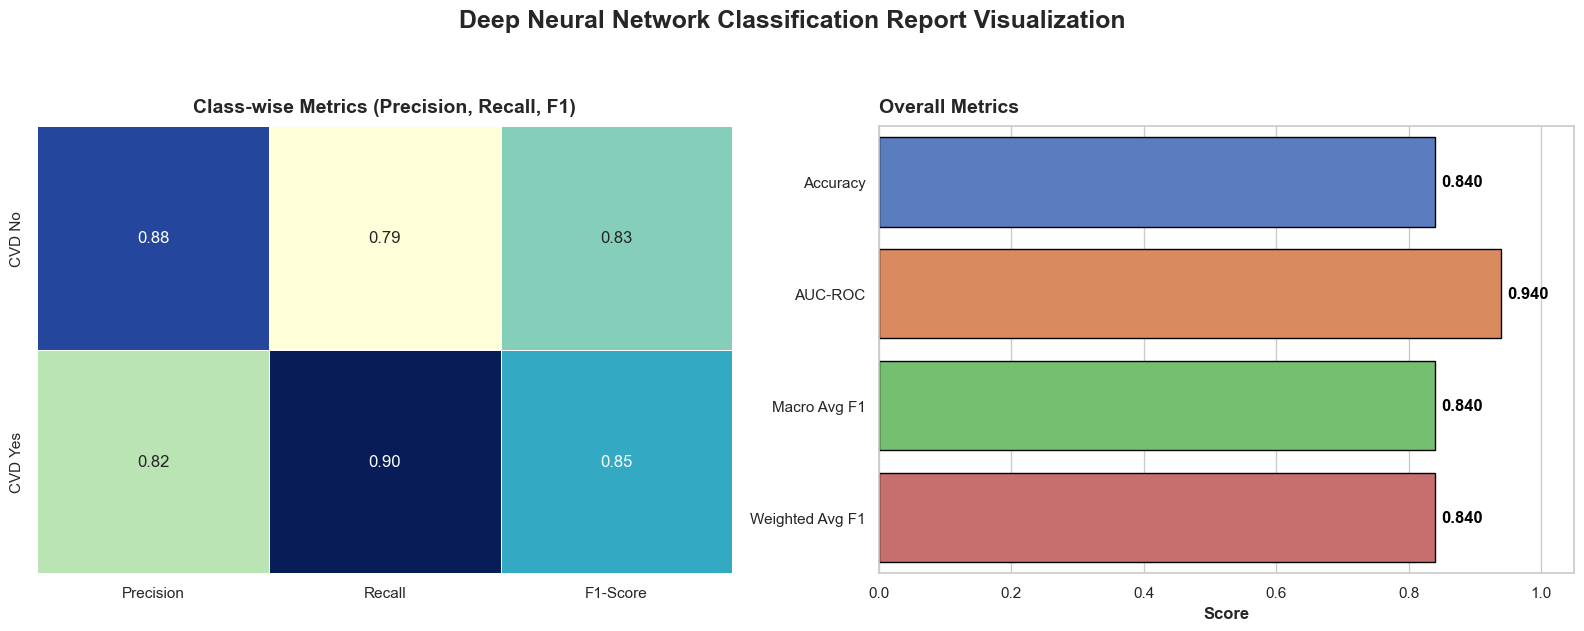

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Updated classification report values
report_dict = {
    'CVD No': {'precision': 0.88, 'recall': 0.79, 'f1-score': 0.83},
    'CVD Yes': {'precision': 0.82, 'recall': 0.90, 'f1-score': 0.85},
    'accuracy': 0.84,
    'macro avg': {'f1-score': 0.84},
    'weighted avg': {'f1-score': 0.84}
}
auc_roc = 0.9399  # AUC-ROC from model evaluation

# Prepare class-wise metrics DataFrame
metrics_data = {
    'Class': ['CVD No', 'CVD Yes'],
    'Precision': [report_dict['CVD No']['precision'], report_dict['CVD Yes']['precision']],
    'Recall': [report_dict['CVD No']['recall'], report_dict['CVD Yes']['recall']],
    'F1-Score': [report_dict['CVD No']['f1-score'], report_dict['CVD Yes']['f1-score']]
}
class_df = pd.DataFrame(metrics_data)

# Prepare overall metrics DataFrame
overall_metrics = {
    'Metric': ['Accuracy', 'AUC-ROC', 'Macro Avg F1', 'Weighted Avg F1'],
    'Score': [
        report_dict['accuracy'],
        auc_roc,
        report_dict['macro avg']['f1-score'],
        report_dict['weighted avg']['f1-score']
    ]
}
overall_df = pd.DataFrame(overall_metrics)

# Set seaborn style
sns.set(style="whitegrid")

# Plot the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.suptitle("Deep Neural Network Classification Report Visualization", fontsize=18, fontweight='bold', y=1.05)

# Heatmap for class-wise metrics
sns.heatmap(
    class_df.set_index('Class'),
    annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5,
    ax=ax1, cbar=False
)
ax1.set_title('Class-wise Metrics (Precision, Recall, F1)', fontsize=14, fontweight='bold', pad=10)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Bar chart for overall metrics
sns.barplot(x='Score', y='Metric', data=overall_df, palette='muted', ax=ax2, edgecolor='black')
for i, row in overall_df.iterrows():
    ax2.text(row.Score + 0.01, i, f"{row.Score:.3f}", color='black', va='center', fontweight='bold', fontsize=12)
ax2.set_xlim(0, 1.05)
ax2.set_title('Overall Metrics', fontsize=14, fontweight='bold', pad=10, loc='left')
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


#### Ploting Confussion Matrics

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
Classification Report:
               precision    recall  f1-score   support

      CVD No       0.88      0.79      0.83      2044
     CVD Yes       0.82      0.90      0.85      2142

    accuracy                           0.84      4186
   macro avg       0.85      0.84      0.84      4186
weighted avg       0.85      0.84      0.84      4186



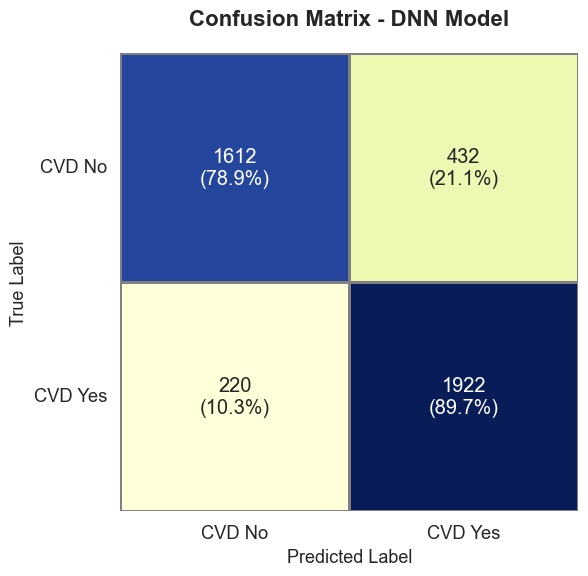

In [146]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities and convert to labels
y_pred_probs = model_DNN.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# If y_test is one-hot encoded
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_test, y_pred, target_names=['CVD No', 'CVD Yes'])
print("Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages for each row (true label)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Class labels
labels = ['CVD No', 'CVD Yes']

# Create annotations with count and percentage
annot = np.array([["{0}\n({1:.1%})".format(count, percent)
                   for count, percent in zip(row, percent_row)]
                  for row, percent_row in zip(cm, cm_percent)])

# Plot the heatmap
plt.figure(figsize=(9, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

sns.heatmap(cm,
            annot=annot,
            fmt='',
            cmap='YlGnBu',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=1,
            linecolor='gray',
            cbar=False,
            square=True)

plt.title('Confusion Matrix - DNN Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Visualizing Training and Testing Accuracy

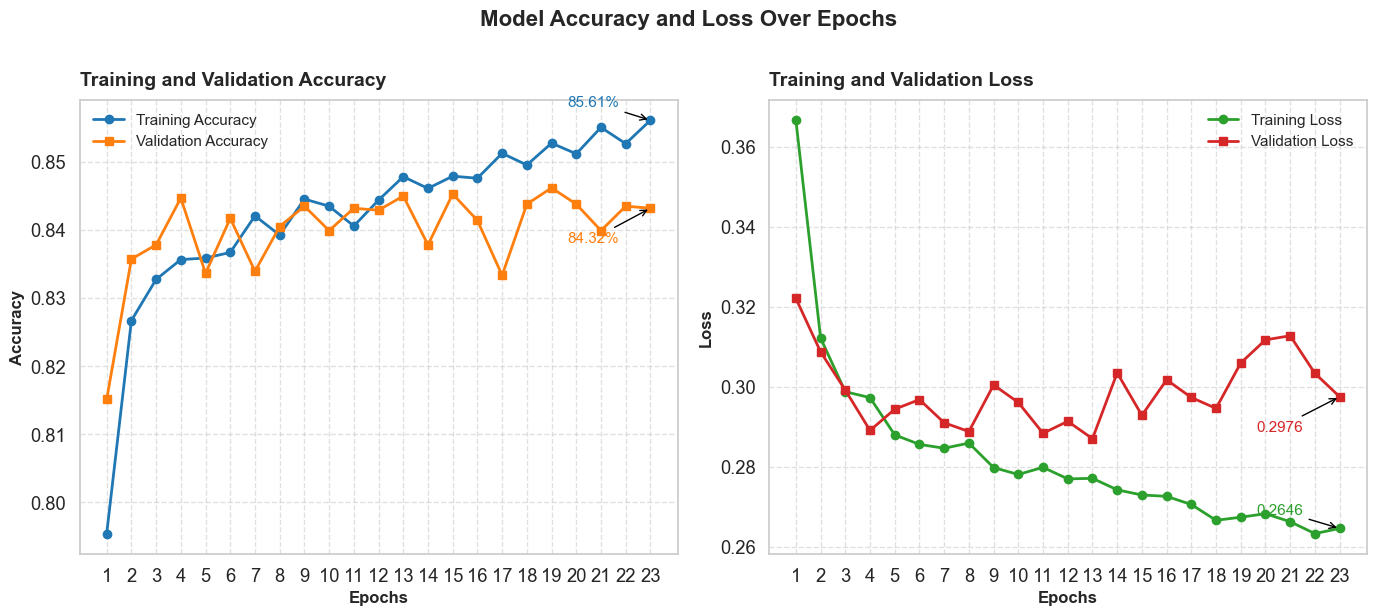

In [163]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
acc = history_DNN.history['accuracy']
val_acc = history_DNN.history['val_accuracy']
loss = history_DNN.history['loss']
val_loss = history_DNN.history['val_loss']
epochs = range(1, len(acc) + 1)

# Final values
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

# Plotting
plt.figure(figsize=(14, 6))

# --- Subplot 1: Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', color='#1f77b4', linewidth=2, marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='#ff7f0e', linewidth=2, marker='s')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold', loc='left', pad=10)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, frameon=False)

# Accuracy annotations
plt.annotate(f'{final_train_acc:.2%}',
             xy=(epochs[-1], final_train_acc),
             xytext=(-60, 10),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='#1f77b4')

plt.annotate(f'{final_val_acc:.2%}',
             xy=(epochs[-1], final_val_acc),
             xytext=(-60, -25),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='#ff7f0e')

# --- Subplot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='#2ca02c', linewidth=2, marker='o')        # Green
plt.plot(epochs, val_loss, label='Validation Loss', color='#d62728', linewidth=2, marker='s')   # Red
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold', loc='left', pad=10)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, frameon=False)

# Loss annotations
plt.annotate(f'{final_train_loss:.4f}',
             xy=(epochs[-1], final_train_loss),
             xytext=(-60, 10),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='#2ca02c')

plt.annotate(f'{final_val_loss:.4f}',
             xy=(epochs[-1], final_val_loss),
             xytext=(-60, -25),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11, color='#d62728')

# Super title and layout
plt.suptitle('Model Accuracy and Loss Over Epochs', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


#### Interprate the model Using LIME

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


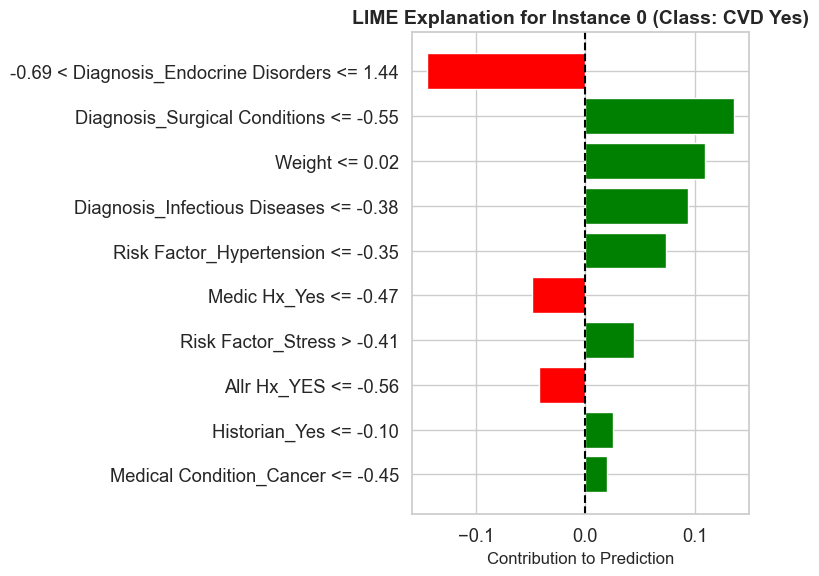

In [ ]:
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Function to return both class probabilities: [P(class=0), P(class=1)]
def predict_proba_fn(x):
    proba_1 = model_DNN.predict(x)  # shape (n, 1)
    proba_0 = 1 - proba_1           # shape (n, 1)
    return np.hstack((proba_0, proba_1))  # shape (n, 2)

# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['CVD No', 'CVD Yes'],
    mode='classification'
)

# Explain a prediction
i = 0  # Choose instance to explain
exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=predict_proba_fn
)

# Extract explanation as list of tuples: (feature, weight)
exp_list = exp.as_list(label=1)  # Class 1 = 'CVD Yes'

# Split into features and weights
features, weights = zip(*exp_list)

# Plot using matplotlib
plt.figure(figsize=(8, 6))
colors = ['green' if w > 0 else 'red' for w in weights]
plt.barh(features, weights, color=colors)
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f"LIME Explanation for Instance {i} (Class: CVD Yes)", fontsize=14, fontweight='bold')
plt.xlabel('Contribution to Prediction', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## End Of the Experiments